In [2]:
import asyncio
import datetime as dt
import math
from typing import Literal

import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import pandas_market_calendars as mcal
import plotly.graph_objects as go
import polars as pl
from dash import Dash, dcc, html
from plotly.subplots import make_subplots

nse = mcal.get_calendar("NSE")

In [3]:
pd.set_option("display.max_rows", 25_000)
pd.set_option("display.max_columns", 500)
pl.Config.set_tbl_cols(500)
pl.Config.set_tbl_rows(10_000)

pd.options.display.float_format = "{:.4f}".format

In [4]:
import sys

sys.path.append("..")
from tooling.enums import AssetClass, Index, Spot, StrikeSpread
from tooling.fetch import fetch_option_data, fetch_spot_data
from tooling.filter import find_atm, option_tool

In [5]:
from fetching_from_local_db.enums import AssetClass, Index, StrikeSpread
from fetching_from_local_db.fetch_from_db import _fetch_batch, fetch_data, fetch_spot_data

In [6]:
from expiries import dict_expiries

In [7]:
def resample(
    data: pl.DataFrame, timeframe, offset: dt.timedelta | None = None
) -> pl.DataFrame:
    return (
        data.set_sorted("datetime")
        .group_by_dynamic(
            index_column="datetime",
            every=timeframe,
            period=timeframe,
            label="left",
            offset=offset,
        )
        .agg(
            [
                pl.col("o").first().alias("o"),
                pl.col("h").max().alias("h"),
                pl.col("l").min().alias("l"),
                pl.col("c").last().alias("c"),
                # pl.col("volume").sum().alias("volume"),
            ]
        )
    )


# ohlc_resampled = resample(pl.DataFrame(bnf_1min), '7d', pd.Timedelta(days=4))
# ohlc_resampled

In [8]:
def generate_stats(tb_expiry, variation):
    stats_df8 = pd.DataFrame(
        index=range(2019, 2026),
        columns=[
            "Total ROI",
            "Total Trades",
            "Win Rate",
            "Avg Profit% per Trade",
            "Avg Loss% per Trade",
            "Max Drawdown",
            "ROI/DD Ratio",
            "Variation",
        ],
    )
    combined_df_sorted = tb_expiry
    # combined_df_sorted = tb_expiry_ce
    # combined_df_sorted = tb_expiry_pe

    # Iterate over each year
    for year in range(2019, 2026):
        # Filter trades for the current year
        year_trades = combined_df_sorted[(combined_df_sorted["Trade Year"] == year)]

        # Calculate total ROI
        total_roi = year_trades["ROI%"].sum()

        # Calculate total number of trades
        total_trades = len(year_trades)

        # Calculate win rate
        win_rate = (year_trades["ROI%"] > 0).mean() * 100

        # Calculate average profit per trade
        avg_profit = year_trades[year_trades["ROI%"] > 0]["ROI%"].mean()

        # Calculate average loss per trade
        avg_loss = year_trades[year_trades["ROI%"] < 0]["ROI%"].mean()

        # Calculate maximum drawdown
        max_drawdown = (
            year_trades["ROI%"].cumsum() - year_trades["ROI%"].cumsum().cummax()
        ).min()

        # Calculate ROI/DD ratio
        roi_dd_ratio = total_roi / abs(max_drawdown)

        variation = f"{variation}"

        # Store the statistics in the DataFrame
        stats_df8.loc[year] = [
            total_roi,
            total_trades,
            win_rate,
            avg_profit,
            avg_loss,
            max_drawdown,
            roi_dd_ratio,
            variation,
        ]

    # Calculate overall statistics
    overall_total_roi = stats_df8["Total ROI"].sum()
    overall_total_trades = stats_df8["Total Trades"].sum()
    overall_win_rate = (combined_df_sorted["ROI%"] > 0).mean() * 100
    overall_avg_profit = combined_df_sorted[combined_df_sorted["ROI%"] > 0][
        "ROI%"
    ].mean()
    overall_avg_loss = combined_df_sorted[combined_df_sorted["ROI%"] < 0]["ROI%"].mean()
    overall_max_drawdown = (
        combined_df_sorted["ROI%"].cumsum()
        - combined_df_sorted["ROI%"].cumsum().cummax()
    ).min()
    overall_roi_dd_ratio = overall_total_roi / abs(overall_max_drawdown)
    overall_variation = variation

    # Store the overall statistics in the DataFrame
    stats_df8.loc["Overall"] = [
        overall_total_roi,
        overall_total_trades,
        overall_win_rate,
        overall_avg_profit,
        overall_avg_loss,
        overall_max_drawdown,
        overall_roi_dd_ratio,
        overall_variation,
    ]
    return {overall_roi_dd_ratio: stats_df8}

In [9]:
bnf_1min = pd.read_csv("../data/nifty_min.csv")

In [10]:
bnf_1min.columns = ['index', 'datetime', 'o', 'h', 'l', 'c', 'v']
# bnf_1min.tail()

In [11]:
bnf_1min["datetime"] = pd.to_datetime(bnf_1min["datetime"]).dt.tz_localize(None)
# bnf_1min = bnf_1min[((bnf_1min['datetime'].dt.year == 2020) & (bnf_1min['datetime'].dt.month == 4))]
bnf_1min = bnf_1min[
    (bnf_1min["datetime"].dt.year >= 2019) & (bnf_1min["datetime"].dt.year <= 2025)
]

In [12]:
# dict_expiries

In [13]:
from datetime import date
from bisect import bisect_left

def get_next_expiry(input_date, index_symbol):
    expiries = dict_expiries.get(index_symbol)
    if not expiries:
        return None
        
    expiry_dates = sorted({dt.date() for dt in expiries})
    pos = bisect_left(expiry_dates, input_date)
    return expiry_dates[pos] if pos < len(expiry_dates) else None


In [14]:
index_ = 'nifty'

if index_ == 'nifty':
    LOT_SIZE_ = 75
    STRIKE_SPREAD_ = 50
    INDEX_LEVERAGE_ = 8
    PORTFOLIO_ = 1_00_00_000

In [15]:
import pandas as pd

async def add_atr(df, period=14):
    """
    Adds an 'ATR' column to the DataFrame using Wilder's smoothing (like TradingView).
    
    Parameters:
    df (pd.DataFrame): Must contain 'h', 'l', 'c' columns for high, low, close
    period (int): ATR period (default 14)
    
    Returns:
    pd.DataFrame: With 'ATR' column added
    """
    high = df['h']
    low = df['l']
    close = df['c']

    # True Range
    tr1 = high - low
    tr2 = (high - close.shift()).abs()
    tr3 = (low - close.shift()).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    # ATR with Wilder's smoothing (like an EMA with alpha=1/period)
    atr = tr.ewm(alpha=1/period, adjust=False).mean()

    df['ATR'] = atr
    return df


In [16]:
async def send_trade(spot_price, entry_timestamp, expiry, direction, atr, tf, offset, dte, tradebook, trade_num, spot_level):
    if direction == 1:
        opt_type = 'C'
        side = 'LONG'
    elif direction == -1:
        opt_type = "P"
        side = 'SHORT'
    else:
        return tradebook

    current_date = entry_timestamp.date()
    current_time = entry_timestamp.time()

    strike = int(round(spot_price / STRIKE_SPREAD_) * STRIKE_SPREAD_) if opt_type == 'C' else int(round(spot_price / STRIKE_SPREAD_) * STRIKE_SPREAD_)

    option_df = await fetch_data(
        index=index_,
        expiry=expiry,
        strike=strike,
        asset_class=opt_type,
        start_date=current_date,
        start_time=entry_timestamp.time(),
        end_date=current_date,
        end_time=dt.time(15, 30),
    )

    if option_df is not None and not isinstance(option_df, str):
        option_df = resample(option_df, tf, offset)
        option_df_pandas = option_df.to_pandas()
        entry_price = option_df_pandas.iloc[0]['c']
    else:
        entry_price = float('nan')

    # print(f'{entry_timestamp} : {side} TRADE Entered ! ')

    trade = {
        'date': current_date,
        # 'high level': high_level,
        # 'low level': low_level,
        # 'atr_multiplier': multiplier,
        'Morning ATR': atr,
        'side': side,
        'strike': strike,
        'type': opt_type,
        'expiry': expiry,
        'dte': dte,
        'entry_time': current_time,
        'entry price': entry_price,
        'trade_num': trade_num,
        'spot_price_at_entry': spot_level,
    }
        
    tradebook.append(trade)
    return tradebook

async def take_exit(strike, opt_type, expiry, exit_timestamp, tf, offset, tradebook, trade_num, spot_level):

    current_date = exit_timestamp.date()
    current_time = exit_timestamp.time()

    strike = int(round(strike / STRIKE_SPREAD_) * STRIKE_SPREAD_) if opt_type == 'C' else int(round(strike / STRIKE_SPREAD_) * STRIKE_SPREAD_)

    if opt_type == 'P':
        side = 'SHORT'
    elif opt_type == 'C':
        side = 'LONG'
    else:
        side = 'None'

    for trade in tradebook:
        if (
            trade['type'] == opt_type and
            trade['date'] == current_date and
            'exit_time' not in trade
        ):
            option_df = await fetch_data(
                index=index_,
                expiry=expiry,
                strike=strike,
                asset_class=opt_type,
                start_date=current_date,
                start_time=current_time,
                end_date=current_date,
                end_time=dt.time(15, 30),
            )
            # print(option_df)
            if option_df is not None and not isinstance(option_df, str):
                option_df = resample(option_df, tf, offset)
                option_df_pandas = option_df.to_pandas()
                exit_price = option_df_pandas.iloc[0]['c']
                # print(f'{side} Trade Exited')
            else:
                exit_price = float('nan')

            if current_time > dt.time(15, 20):
                remark = 'EOD Exit'
            else:
                remark = 'TSL Hit'

            # print(f'{exit_timestamp} : {side} {remark}')

            if option_df is not None and not isinstance(option_df, str):
                trade['exit price'] = exit_price
                trade['exit_time'] = option_df_pandas['datetime'].iloc[0] if len(option_df_pandas) != 0 else float('nan')
                trade['spot_level_at_exit'] = spot_level
                trade['remarks'] = remark
                # trade['high level at exit'] = high_level
                # trade['low level at exit'] = low_level
                trade['points'] = trade['exit price'] - trade['entry price']
            else:
                trade['exit price'] = float('nan')
                trade['exit_time'] = float('nan')
                trade['spot_level_at_exit'] = spot_level
                trade['remarks'] = remark
                # trade['high level at exit'] = high_level
                # trade['low level at exit'] = low_level
                trade['points'] = trade['exit price'] - trade['entry price']

    return tradebook

In [34]:
async def backtest_intraday_levels2(df, multiplier, tf, offset):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df[df['datetime'].dt.year >= 2022]
    df['date'] = df['datetime'].dt.date
    # print(df.head().to_string())
    
    tradebook = []

    eod_time = dt.time(15, 20)
    no_more_trade_time = dt.time(15, 0)
    allowed_dte = [0, 1, 2, 3, 6]

    for date, group in df.groupby('date'):
        current_date = date
        group = group.reset_index(drop=True)
        # print(date)
        # Get 9:15 candle
        morning_candle = group[group['datetime'].dt.time == pd.to_datetime("09:15").time()]
        if morning_candle.empty:
            continue

        morning_atr = morning_candle.iloc[0]['ATR']
        running_high = group.iloc[0]['h'] # Initialising
        running_low = group.iloc[0]['l'] # Initialising

        is_high_breached = False
        is_low_breached = False

        in_trade_long = False
        in_trade_short = False

        data_fetched_pe = False
        data_fetched_ce = False

        trade_num = 1
        max_trades = 25

        for i in range(0, len(group)):
            row = group.iloc[i]
            previous_row = group.iloc[i-1]
            running_high = max(running_high, row['h'])
            running_low = min(running_low, row['l'])
            
            current_datetime = row['datetime']
            
            high_level = running_low + (multiplier * morning_atr)
            low_level = running_high - (multiplier * morning_atr)
            
            long_tsl = low_level
            short_tsl = high_level
            
            # print(row)
            # print(group.iloc[i]['datetime'], high_level, low_level, row['c'])
            # print(f'RH : {running_high} , RL : {running_low}')

            # high_strike = int(round(high_level / STRIKE_SPREAD_) * STRIKE_SPREAD_)
            # low_strike = int(round(low_level / STRIKE_SPREAD_) * STRIKE_SPREAD_)

            expiry = get_next_expiry(date, index_)
            dte = (expiry - current_date).days            

            if not in_trade_long and not in_trade_short and current_datetime.time() <= no_more_trade_time and dte in allowed_dte:
                if row['c'] >= high_level and trade_num <= max_trades:
                    tradebook = await send_trade(high_level, current_datetime, expiry, 1, morning_atr, tf, offset, dte, tradebook, trade_num, row['c'])
                    trade_num += 1
                    # is_high_breached = True
                    in_trade_long = True
                    long_tsl = low_level

            if in_trade_long:
                if row['c'] <= long_tsl:
                    # TSL Hit
                    tradebook = await take_exit(high_level, 'C', expiry, current_datetime, tf, offset, tradebook, trade_num, row['c'])
                    in_trade_long = False
                    # is_high_breached = False

                    # Send Short Trade
                    running_low = row['l']
                    # print(f'Running Low changed to {running_low}')
                    high_level = running_low + (multiplier * morning_atr)
                    # print(f'High Level changed to {high_level}')
                    if trade_num <= max_trades and current_datetime.time() <= no_more_trade_time and dte in allowed_dte:
                        tradebook = await send_trade(long_tsl, current_datetime, expiry, -1, morning_atr, tf, offset, dte, tradebook, trade_num, row['c'])
                        trade_num += 1
                        long_tsl = float('inf')
                        short_tsl = high_level
                        in_trade_short = True
                        # is_low_breached = True
                    else:
                        continue
                    
                elif current_datetime.time() >= eod_time:
                    # EOD Exit
                    tradebook = await take_exit(high_level, 'C', expiry, current_datetime, tf, offset, tradebook, trade_num, row['c'])
    
                    in_trade_long = False
                    # is_high_breached = False
                    long_tsl = float('inf')

            if not in_trade_short and not in_trade_long and current_datetime.time() <= no_more_trade_time and dte in allowed_dte:
                if row['c'] <= low_level and trade_num <= max_trades:
                    tradebook = await send_trade(low_level, current_datetime, expiry, -1, morning_atr, tf, offset, dte, tradebook, trade_num, row['c'])
                    trade_num += 1
                    
                    # is_low_breached = True
                    in_trade_short = True

            if in_trade_short:
                if row['c'] >= short_tsl:
                    # TSL Hit
                    tradebook = await take_exit(low_level, 'P', expiry, current_datetime, tf, offset, tradebook, trade_num, row['c'])
                    
                    in_trade_short = False
                    # is_low_breached = False

                    # Send Long Trade
                    running_high = row['h']
                    # print(f'Running High changed to {running_high}')
                    low_level = running_high - (multiplier * morning_atr)
                    # print(f'Low Level changed to {low_level}')
                    if trade_num <= max_trades and current_datetime.time() <= no_more_trade_time and dte in allowed_dte:
                        tradebook = await send_trade(short_tsl, current_datetime, expiry, 1, morning_atr, tf, offset, dte, tradebook, trade_num, row['c'])
                        trade_num += 1
                        short_tsl = float('-inf')
                        long_tsl = low_level
                        in_trade_long = True
                        # is_high_breached = True
                    else:
                        continue

                elif current_datetime.time() >= eod_time:
                    # EOD Exit
                    tradebook = await take_exit(low_level, 'P', expiry, current_datetime, tf, offset, tradebook, trade_num, row['c'])

                    in_trade_short = False
                    # is_low_breached = False
                    short_tsl = float('-inf')

    tb = pd.DataFrame(tradebook)
    if len(tb) > 0:
        tb['index_lev'] = 8  # default for all

        tb.loc[tb['dte'] == 0, 'index_lev'] = 10
        tb.loc[(tb['dte'].isin([2, 6])) & (tb['type'] == 'PE'), 'index_lev'] = 9
        tb.loc[(tb['dte'].isin([2, 6])) & (tb['type'] == 'CE'), 'index_lev'] = 4

        tb['exit_time'] = pd.to_datetime(tb['exit_time'])
        tb['slippage'] = 0.01 * (tb['entry price'] + tb['exit price'])
        tb['final_points'] = tb['points'] - tb['slippage']
        tb['portfolio'] = PORTFOLIO_
        tb['qty'] = tb['portfolio'] * tb['index_lev'] / tb['strike']
        tb['pnl'] = tb['final_points'] * tb['qty']
        tb['ROI%'] = tb['pnl'] * 100 / tb['portfolio']
        tb['Trade Year'] = tb['exit_time'].dt.year

    return tb

In [23]:
TF_ = '5m'
OFFSET_ = '0m'
ATR_WINDOW_ = 14
MULTIPLIER_ = 2
bnf_df = resample(pl.DataFrame(bnf_1min), TF_, OFFSET_)
bnf_df_pandas = bnf_df.to_pandas()
bnf_df_pandas = await add_atr(bnf_df_pandas, ATR_WINDOW_)
tb = await backtest_intraday_levels2(bnf_df_pandas, MULTIPLIER_, TF_, OFFSET_)
# tb

/tmp/ipykernel_3396/3389977736.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


2025-01-01
2025-01-02
2025-01-03
2025-01-06
2025-01-07
2025-01-08
2025-01-09
2025-01-10
2025-01-13
2025-01-14
2025-01-15
2025-01-16
2025-01-17
2025-01-20
2025-01-21
2025-01-22
2025-01-23
2025-01-24
2025-01-27
2025-01-28
2025-01-29
2025-01-30
2025-01-31
2025-02-01
2025-02-03
2025-02-04
2025-02-05
2025-02-06
2025-02-07
2025-02-10
2025-02-11
2025-02-12
2025-02-13
2025-02-14
2025-02-17
2025-02-18
2025-02-19
2025-02-20
2025-02-21
2025-02-24
2025-02-25
2025-02-27
2025-02-28
2025-03-03
2025-03-04
2025-03-05
2025-03-06
2025-03-07
2025-03-10
2025-03-11
2025-03-12
2025-03-13
2025-03-17
2025-03-18
2025-03-19
2025-03-20
2025-03-21
2025-03-24
2025-03-25
2025-03-26
2025-03-27
2025-03-28
2025-04-01
2025-04-02
2025-04-03
2025-04-04
2025-04-07
2025-04-08
2025-04-09
2025-04-11
2025-04-15
2025-04-16
2025-04-17
2025-04-21
2025-04-22
2025-04-23
2025-04-24
2025-04-25
2025-04-28
2025-04-29
2025-04-30
2025-05-02
2025-05-05
2025-05-06
2025-05-07
2025-05-08
2025-05-09
2025-05-12
2025-05-13
2025-05-14
2025-05-15

In [24]:
if len(tb) > 0:
    tb['index_lev'] = 8  # default for all

    tb.loc[tb['dte'] >= 0, 'index_lev'] = 10
    # tb.loc[(tb['dte'].isin([2, 6])) & (tb['type'] == 'P'), 'index_lev'] = 9
    # tb.loc[(tb['dte'].isin([2, 6])) & (tb['type'] == 'C'), 'index_lev'] = 3

    tb['exit_time'] = pd.to_datetime(tb['exit_time'])
    tb['slippage'] = 0.01 * (tb['entry price'] + tb['exit price'])
    tb['final_points'] = tb['points'] - tb['slippage']
    tb['portfolio'] = PORTFOLIO_
    tb['qty'] = tb['portfolio'] * tb['index_lev'] / tb['strike']
    tb['pnl'] = tb['final_points'] * tb['qty']
    tb['ROI%'] = tb['pnl'] * 100 / tb['portfolio']
    tb['Trade Year'] = tb['exit_time'].dt.year

In [25]:
tb_may = tb[-61:]
# tb[tb['Trade Year'] >= 2025].tail(65)
tb_may

,date,Morning ATR,side,strike,type,expiry,dte,entry_time,entry price,trade_num,spot_price_at_entry,exit price,exit_time,spot_level_at_exit,remarks,points,index_lev,slippage,final_points,portfolio,qty,pnl,ROI%,Trade Year
444,2025-05-19,19.2845,SHORT,25000,P,2025-05-22,3,09:25:00,166.6000,2,25014.4500,159.3500,2025-05-19 09:45:00,25018.1000,TSL Hit,-7.2500,10,3.2595,-10.5095,10000000,4000.0000,-42038.0000,-0.4204,2025
445,2025-05-19,19.2845,LONG,25000,C,2025-05-22,3,09:45:00,176.7000,3,25018.1000,180.8500,2025-05-19 10:25:00,25024.1000,TSL Hit,4.1500,10,3.5755,0.5745,10000000,4000.0000,2298.0000,0.0230,2025
446,2025-05-19,19.2845,SHORT,25000,P,2025-05-22,3,10:25:00,149.7500,4,25024.1000,144.4000,2025-05-19 11:00:00,25041.8500,TSL Hit,-5.3500,10,2.9415,-8.2915,10000000,4000.0000,-33166.0000,-0.3317,2025
447,2025-05-19,19.2845,LONG,25050,C,2025-05-22,3,11:00:00,165.2000,5,25041.8500,145.3500,2025-05-19 11:45:00,24999.9000,TSL Hit,-19.8500,10,3.1055,-22.9555,10000000,3992.0160,-91638.7226,-0.9164,2025
448,2025-05-19,19.2845,SHORT,25000,P,2025-05-22,3,11:45:00,161.5000,6,24999.9000,146.5500,2025-05-19 12:50:00,25014.2000,TSL Hit,-14.9500,10,3.0805,-18.0305,10000000,4000.0000,-72122.0000,-0.7212,2025
449,2025-05-19,19.2845,LONG,25000,C,2025-05-22,3,12:50:00,168.1000,7,25014.2000,144.7500,2025-05-19 13:45:00,24974.7500,TSL Hit,-23.3500,10,3.1285,-26.4785,10000000,4000.0000,-105914.0000,-1.0591,2025
450,2025-05-19,19.2845,SHORT,25000,P,2025-05-22,3,13:45:00,163.9000,8,24974.7500,186.0000,2025-05-19 14:15:00,24958.7000,TSL Hit,22.1000,10,3.4990,18.6010,10000000,4000.0000,74404.0000,0.7440,2025
451,2025-05-19,19.2845,LONG,24950,C,2025-05-22,3,14:15:00,157.7000,9,24958.7000,147.1500,2025-05-19 15:20:00,24945.2500,TSL Hit,-10.5500,10,3.0485,-13.5985,10000000,4008.0160,-54503.0060,-0.5450,2025
452,2025-05-20,20.6587,SHORT,24950,P,2025-05-22,2,09:20:00,129.6000,1,24960.0000,132.1500,2025-05-20 10:35:00,24929.0000,TSL Hit,2.5500,10,2.6175,-0.0675,10000000,4008.0160,-270.5411,-0.0027,2025
453,2025-05-20,20.6587,LONG,24900,C,2025-05-22,2,10:35:00,157.6000,2,24929.0000,161.2000,2025-05-20 11:10:00,24920.7500,TSL Hit,3.6000,10,3.1880,0.4120,10000000,4016.0643,1654.6185,0.0165,2025


In [26]:
# tb_may.to_csv('scalper_may.csv', index=False)

In [27]:
tb['ROI%'].sum()

-32.58676157648287

In [28]:
stats = generate_stats(tb, 'ATR Dynamic')
for x, y in stats.items():
    z = pd.DataFrame(y)
    break

z

,Total ROI,Total Trades,Win Rate,Avg Profit% per Trade,Avg Loss% per Trade,Max Drawdown,ROI/DD Ratio,Variation
2019,0.0000,0,NaN,NaN,NaN,NaN,NaN,ATR Dynamic
2020,0.0000,0,NaN,NaN,NaN,NaN,NaN,ATR Dynamic
2021,0.0000,0,NaN,NaN,NaN,NaN,NaN,ATR Dynamic
2022,0.0000,0,NaN,NaN,NaN,NaN,NaN,ATR Dynamic
2023,0.0000,0,NaN,NaN,NaN,NaN,NaN,ATR Dynamic
2024,0.0000,0,NaN,NaN,NaN,NaN,NaN,ATR Dynamic
2025,-32.5868,505,34.4554,1.7350,-1.0105,-42.2676,-0.7710,ATR Dynamic
Overall,-32.5868,505,34.4554,1.7350,-1.0105,-42.2676,-0.7710,ATR Dynamic


In [130]:
stats = generate_stats(tb, 'ATR Dynamic')
for x, y in stats.items():
    z = pd.DataFrame(y)
    break

z

,Total ROI,Total Trades,Win Rate,Avg Profit% per Trade,Avg Loss% per Trade,Max Drawdown,ROI/DD Ratio,Variation
2019,109.1563,522,50.9579,1.1667,-0.7859,-8.7944,12.4121,ATR Dynamic
2020,274.3075,589,54.4992,1.9992,-1.3710,-18.9987,14.4382,ATR Dynamic
2021,106.0451,612,50.4902,1.2715,-0.9467,-21.0988,5.0261,ATR Dynamic
2022,139.7454,556,53.5971,1.3295,-0.9940,-17.1861,8.1313,ATR Dynamic
2023,36.7819,601,48.2529,0.8606,-0.6842,-12.7855,2.8768,ATR Dynamic
2024,76.7475,677,48.1536,1.0651,-0.7706,-22.2215,3.4537,ATR Dynamic
2025,30.2279,180,58.8889,0.8815,-0.8542,-8.3276,3.6298,ATR Dynamic
Overall,773.0116,3737,50.9033,1.2690,-0.9107,-22.2215,34.7866,ATR Dynamic


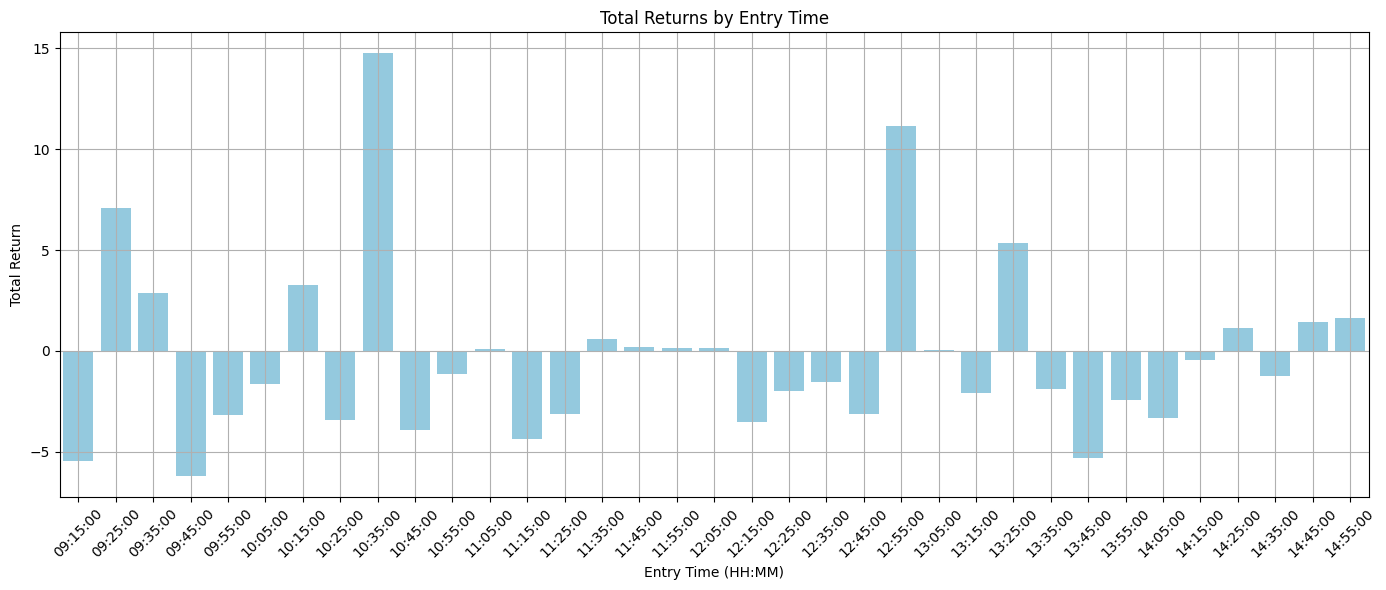

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = tb.copy()  # your DataFrame

# Step 1: Convert time to string format (HH:MM) for better x-axis display
df['entry_time_str'] = df['entry_time'].apply(lambda t: t.strftime('%H:%M:%S'))

# Step 2: Group by time and sum the returns
agg_df = df.groupby('entry_time_str')['ROI%'].sum().reset_index()

# Step 3: Plot the summed returns by time
plt.figure(figsize=(14, 6))
sns.barplot(x='entry_time_str', y='ROI%', data=agg_df, color='skyblue')
plt.xticks(rotation=45)
plt.title('Total Returns by Entry Time')
plt.xlabel('Entry Time (HH:MM)')
plt.ylabel('Total Return')
plt.grid(True)
plt.tight_layout()
plt.show()


In [179]:
# tb.to_csv('ATR_Dynamic_JJMS_10m_14_2.csv', index=False)

In [180]:
# tb = tb_with_hedge
tb['Cumulative ROI%'] = tb['ROI%'].cumsum()
tb['Max Cumulative ROI%'] = tb['Cumulative ROI%'].cummax()  # Maximum value so far
tb['DD'] = tb['Cumulative ROI%'] - tb['Max Cumulative ROI%']  # Drawdown
tb.tail()

,date,Morning ATR,side,strike,type,expiry,dte,entry_time,entry price,trade_num,exit price,exit_time,remarks,points,index_lev,slippage,final_points,portfolio,qty,pnl,ROI%,Trade Year,Cumulative ROI%,Max Cumulative ROI%,DD
3759,2025-03-28,29.4007,SHORT,23550,C,2025-04-03,6,09:15:00,189.6500,1,227.3000,2025-03-28 10:25:00,TSL Hit,-37.6500,3,4.1695,-41.8195,10000000,1273.8854,-53273.2484,-0.5327,2025.0000,772.4525,772.9852,-0.5327
3760,2025-03-28,29.4007,LONG,23550,P,2025-04-03,6,10:25:00,93.9500,2,109.0000,2025-03-28 11:05:00,TSL Hit,-15.0500,9,2.0295,-17.0795,10000000,3821.6561,-65271.9745,-0.6527,2025.0000,771.7998,772.9852,-1.1855
3761,2025-03-28,29.4007,SHORT,23600,C,2025-04-03,6,11:05:00,156.5000,3,93.0000,2025-03-28 14:15:00,TSL Hit,63.5000,3,2.4950,61.0050,10000000,1271.1864,77548.7288,0.7755,2025.0000,772.5753,772.9852,-0.4100
3762,2025-03-28,29.4007,LONG,23500,P,2025-04-03,6,14:15:00,111.0000,4,98.1000,2025-03-28 14:55:00,TSL Hit,12.9000,9,2.0910,10.8090,10000000,3829.7872,41396.1702,0.4140,2025.0000,772.9892,772.9892,0.0000
3763,2025-03-28,29.4007,SHORT,23550,C,2025-04-03,6,14:55:00,116.7000,5,112.6500,2025-03-28 15:25:00,EOD Exit,4.0500,3,2.2935,1.7565,10000000,1273.8854,2237.5796,0.0224,2025.0000,773.0116,773.0116,0.0000


In [181]:
import pandas as pd

def calculate_dte_stats(df):
    # Check required columns
    # print(df.columns)
    if 'dte' not in df.columns or 'ROI%' not in df.columns or 'DD' not in df.columns or 'type' not in df.columns:
        raise ValueError("DataFrame must contain 'dte', 'ROI%', 'DD', and 'type' columns.")
    
    # Add win flag
    df['is_win'] = df['ROI%'] > 0

    # Group by both DTE and Option Type
    grouped_stats = df.groupby(['dte', 'type']).agg(
        returns_sum=('ROI%', 'sum'),
        max_drawdown=('DD', 'min'),
        total_trades=('dte', 'count'),
        wins=('is_win', 'sum')
    ).reset_index()

    # Calculate ratio of returns sum to max drawdown
    grouped_stats['returns_to_max_dd_ratio'] = (
        grouped_stats['returns_sum'] / grouped_stats['max_drawdown'].abs()
    )

    # Calculate win rate
    grouped_stats['win_rate'] = (grouped_stats['wins'] / grouped_stats['total_trades']) * 100

    return grouped_stats


In [182]:
import pandas as pd

def calculate_opt_type_stats(df):

    # print(df.columns)
    if 'type' not in df.columns or 'ROI%' not in df.columns or 'DD' not in df.columns:
        raise ValueError("DataFrame must contain 'DTE', 'returns', and 'drawdown' columns.")
    
    # Group by DTE and calculate required stats
    grouped_stats = df.groupby('type').agg(
        returns_sum=('ROI%', 'sum'),
        max_drawdown=('DD', 'min'),  # Assuming 'drawdown' contains negative values
        total_trades=('type', 'count')
    ).reset_index()
    
    # Calculate ratio of returns sum to max drawdown
    grouped_stats['returns_to_max_dd_ratio'] = (
        grouped_stats['returns_sum'] / grouped_stats['max_drawdown'].abs()
    )

    return grouped_stats


In [183]:
import pandas as pd

def calculate_trade_num_stats(df):

    # print(df.columns)
    if 'trade_num' not in df.columns or 'ROI%' not in df.columns or 'DD' not in df.columns:
        raise ValueError("DataFrame must contain 'DTE', 'returns', and 'drawdown' columns.")
    
    # Group by DTE and calculate required stats
    grouped_stats = df.groupby('trade_num').agg(
        returns_sum=('ROI%', 'sum'),
        max_drawdown=('DD', 'min'),  # Assuming 'drawdown' contains negative values
        total_trades=('trade_num', 'count')
    ).reset_index()
    
    # Calculate ratio of returns sum to max drawdown
    grouped_stats['returns_to_max_dd_ratio'] = (
        grouped_stats['returns_sum'] / grouped_stats['max_drawdown'].abs()
    )

    return grouped_stats


In [184]:
stats_dte = calculate_dte_stats(tb)
stats_dte

,dte,type,returns_sum,max_drawdown,total_trades,wins,returns_to_max_dd_ratio,win_rate
0,0,C,127.0698,-20.9351,381,237,6.0697,62.2047
1,0,P,146.1979,-20.7619,395,237,7.0417,60.0000
2,1,C,54.3375,-22.2215,375,183,2.4453,48.8000
3,1,P,82.2688,-21.9634,408,202,3.7457,49.5098
4,2,C,15.5697,-20.8096,375,182,0.7482,48.5333
5,2,P,152.8115,-20.9452,411,208,7.2958,50.6083
6,3,C,51.4078,-21.0560,312,145,2.4415,46.4744
7,3,P,66.1636,-20.4069,321,169,3.2422,52.6480
8,6,C,8.6541,-20.1075,386,170,0.4304,44.0415
9,6,P,68.5310,-20.2386,400,183,3.3861,45.7500


In [185]:
stats_opt_type = calculate_opt_type_stats(tb)
stats_opt_type

,type,returns_sum,max_drawdown,total_trades,returns_to_max_dd_ratio
0,C,257.0389,-22.2215,1829,11.5671
1,P,515.9727,-21.9634,1935,23.4923


In [186]:
stats_trade_num = calculate_trade_num_stats(tb)
stats_trade_num

,trade_num,returns_sum,max_drawdown,total_trades,returns_to_max_dd_ratio
0,1,346.1153,-20.9452,1467,16.5248
1,2,199.9836,-22.2215,1081,8.9995
2,3,145.0734,-21.9634,668,6.6052
3,4,29.4433,-21.8603,323,1.3469
4,5,36.1697,-19.7946,126,1.8273
5,6,6.4741,-21.1125,57,0.3066
6,7,4.1873,-15.0308,24,0.2786
7,8,6.9914,-8.5778,11,0.8151
8,9,-2.0832,-5.3309,3,-0.3908
9,10,-0.0529,-5.0157,3,-0.0106


In [38]:
# SIMULATION

TF_ = ['3m', '5m', '10m']
ATR_WINDOW_ = [4, 7, 10, 13, 16, 19, 22]
MULTIPLIER_ = [1, 2, 3, 4, 5, 6, 7]

for i in TF_:
    for j in ATR_WINDOW_:
        for k in MULTIPLIER_:
            if i == '10m':
                z = '5m'
            else:
                z = '0m'
            variation = f'TF: {i}, ATR: {j}, MULT: {k}'
            print(variation)
            bnf_df = resample(pl.DataFrame(bnf_1min), i, z)
            bnf_df_pandas = bnf_df.to_pandas()
            bnf_df_pandas = await add_atr(bnf_df_pandas, j)
            tb = await backtest_intraday_levels2(bnf_df_pandas, k, i, z)

            if len(tb) > 0:
                stats = generate_stats(tb, variation)
                for x, y in stats.items():
                    if x > -2:
                        q = pd.DataFrame(y)
                        print(q.to_string())


TF: 3m, ATR: 4, MULT: 1


/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 4, MULT: 1
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 4, MULT: 1
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 4, MULT: 1
2022    -112.2474         1941  32.9212                1.2174             -0.6837    -118.7406      -0.9453  TF: 3m, ATR: 4, MULT: 1
2023     -16.0486         2101  33.6982                0.8214             -0.4290     -39.2305      -0.4091  TF: 3m, ATR: 4, MULT: 1
2024    -114.3509         2666  30.1200                1.0216             -0.5017    -137.0354      -0.8345  TF: 3m, ATR: 4, MULT: 1
2025     -97.4719         1062  30.0377                0.9863        

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 4, MULT: 2
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 4, MULT: 2
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 4, MULT: 2
2022     -14.5086          693  35.2092                1.9761             -1.1062     -56.7292      -0.2558  TF: 3m, ATR: 4, MULT: 2
2023     -12.3339          737  34.0570                1.3681             -0.7320     -32.3180      -0.3816  TF: 3m, ATR: 4, MULT: 2
2024      -0.1336          900  33.7778                1.7466             -0.8911     -36.8303      -0.0036  TF: 3m, ATR: 4, MULT: 2
2025     -42.9287          375  31.2000                1.6917        

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 4, MULT: 3
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 4, MULT: 3
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 4, MULT: 3
2022      65.1823          342  40.9357                2.5485             -1.4436     -31.2675       2.0847  TF: 3m, ATR: 4, MULT: 3
2023      -6.6943          395  35.6962                1.6251             -0.9285     -37.1581      -0.1802  TF: 3m, ATR: 4, MULT: 3
2024     -31.3297          494  30.9717                2.4344             -1.1841     -45.6652      -0.6861  TF: 3m, ATR: 4, MULT: 3
2025     -13.3387          187  34.2246                2.0506        

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 4, MULT: 4
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 4, MULT: 4
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 4, MULT: 4
2022      26.4028          223  44.3946                2.4188             -1.7182     -25.1732       1.0488  TF: 3m, ATR: 4, MULT: 4
2023     -21.7484          241  37.3444                1.6690             -1.1388     -38.0269      -0.5719  TF: 3m, ATR: 4, MULT: 4
2024     -16.2688          303  35.3135                2.4088             -1.3980     -31.3349      -0.5192  TF: 3m, ATR: 4, MULT: 4
2025     -19.1714          123  34.1463                2.0698        

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 4, MULT: 5
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 4, MULT: 5
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 4, MULT: 5
2022      18.1477          149  41.6107                2.5851             -1.6337     -24.6736       0.7355  TF: 3m, ATR: 4, MULT: 5
2023     -35.2733          168  36.9048                1.5614             -1.2460     -44.2382      -0.7973  TF: 3m, ATR: 4, MULT: 5
2024      10.0640          199  39.1960                2.4118             -1.4715     -18.4034       0.5469  TF: 3m, ATR: 4, MULT: 5
2025     -44.3041           94  26.5957                2.3761        

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 4, MULT: 6
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 4, MULT: 6
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 4, MULT: 6
2022       5.0991           99  45.4545                2.3629             -1.8747     -33.1601       0.1538  TF: 3m, ATR: 4, MULT: 6
2023     -19.6877          106  42.4528                1.4088             -1.3620     -29.3457      -0.6709  TF: 3m, ATR: 4, MULT: 6
2024      -8.0061          142  40.1408                2.3250             -1.6533     -22.3726      -0.3579  TF: 3m, ATR: 4, MULT: 6
2025     -19.7895           62  27.4194                2.8966        

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 4, MULT: 7
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 4, MULT: 7
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 4, MULT: 7
2022       7.3754           60  50.0000                2.0632             -1.8174     -20.6505       0.3572  TF: 3m, ATR: 4, MULT: 7
2023     -10.1042           71  40.8451                1.4485             -1.2407     -17.5464      -0.5759  TF: 3m, ATR: 4, MULT: 7
2024      -0.1618          102  40.1961                2.2933             -1.5440     -25.0748      -0.0065  TF: 3m, ATR: 4, MULT: 7
2025      -7.3303           42  30.9524                3.0559        

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 7, MULT: 1
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 7, MULT: 1
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 7, MULT: 1
2022    -173.6040         2844  32.2082                1.0165             -0.5730    -183.9756      -0.9436  TF: 3m, ATR: 7, MULT: 1
2023     -53.0630         2974  31.7418                0.7109             -0.3567     -76.4846      -0.6938  TF: 3m, ATR: 7, MULT: 1
2024    -217.3129         3603  28.6983                0.8746             -0.4366    -221.9463      -0.9791  TF: 3m, ATR: 7, MULT: 1
2025    -120.9963         1457  29.6500                0.8119        

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 7, MULT: 2
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 7, MULT: 2
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 7, MULT: 2
2022      33.2911          994  36.1167                1.7154             -0.9174     -41.4777       0.8026  TF: 3m, ATR: 7, MULT: 2
2023     -25.1170         1041  32.9491                1.2351             -0.6429     -44.8632      -0.5599  TF: 3m, ATR: 7, MULT: 2
2024     -31.3087         1252  32.1086                1.5628             -0.7760     -73.9066      -0.4236  TF: 3m, ATR: 7, MULT: 2
2025     -68.3146          565  29.5575                1.4678        

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 7, MULT: 3
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 7, MULT: 3
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 7, MULT: 3
2022     -35.6187          555  34.9550                2.2606             -1.3135     -75.9022      -0.4693  TF: 3m, ATR: 7, MULT: 3
2023     -28.1171          579  32.9879                1.5658             -0.8433     -59.3980      -0.4734  TF: 3m, ATR: 7, MULT: 3
2024      27.6869          658  33.8906                2.1599             -1.0436     -41.8024       0.6623  TF: 3m, ATR: 7, MULT: 3
2025      -1.0185          276  33.6957                2.0095        

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 7, MULT: 4
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 7, MULT: 4
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 7, MULT: 4
2022      39.1425          337  39.7626                2.6534             -1.5587     -35.2348       1.1109  TF: 3m, ATR: 7, MULT: 4
2023      -9.5290          351  37.6068                1.6630             -1.0459     -33.9094      -0.2810  TF: 3m, ATR: 7, MULT: 4
2024     -33.8657          446  30.7175                2.4832             -1.2106     -44.4147      -0.7625  TF: 3m, ATR: 7, MULT: 4
2025     -13.0057          183  34.4262                2.0553        

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 7, MULT: 5
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 7, MULT: 5
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 7, MULT: 5
2022       4.1621          242  42.1488                2.4594             -1.7621     -29.7094       0.1401  TF: 3m, ATR: 7, MULT: 5
2023     -24.8462          245  37.5510                1.6674             -1.1650     -42.9535      -0.5784  TF: 3m, ATR: 7, MULT: 5
2024       3.9715          297  35.3535                2.5231             -1.3591     -35.0034       0.1135  TF: 3m, ATR: 7, MULT: 5
2025     -34.2157          138  31.8841                2.0795        

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 7, MULT: 6
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 7, MULT: 6
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 7, MULT: 6
2022      11.3780          171  41.5205                2.5303             -1.6827     -27.7584       0.4099  TF: 3m, ATR: 7, MULT: 6
2023     -22.0422          176  39.7727                1.5587             -1.2373     -38.5605      -0.5716  TF: 3m, ATR: 7, MULT: 6
2024     -13.1805          226  38.0531                2.3897             -1.5621     -34.9780      -0.3768  TF: 3m, ATR: 7, MULT: 6
2025     -32.5297          103  31.0680                2.1490        

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 7, MULT: 7
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 7, MULT: 7
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 7, MULT: 7
2022       8.1086          130  44.6154                2.3215             -1.7575     -27.1091       0.2991  TF: 3m, ATR: 7, MULT: 7
2023     -16.7161          121  43.8017                1.4520             -1.3776     -30.5718      -0.5468  TF: 3m, ATR: 7, MULT: 7
2024      25.7952          155  45.1613                2.2980             -1.5890     -18.8528       1.3682  TF: 3m, ATR: 7, MULT: 7
2025     -42.1292           82  29.2683                2.2443        

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 10, MULT: 1
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 10, MULT: 1
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 10, MULT: 1
2022    -242.8237         3417  30.8750                0.9302             -0.5183    -251.5835      -0.9652  TF: 3m, ATR: 10, MULT: 1
2023     -81.1152         3481  30.1063                0.6774             -0.3251    -100.2504      -0.8091  TF: 3m, ATR: 10, MULT: 1
2024    -231.9384         4089  29.5182                0.7548             -0.3966    -237.8021      -0.9753  TF: 3m, ATR: 10, MULT: 1
2025    -143.5092         1676  29.2959                0.7490 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 10, MULT: 2
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 10, MULT: 2
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 10, MULT: 2
2022     -12.4295         1211  34.6821                1.5804             -0.8548     -56.3022      -0.2208  TF: 3m, ATR: 10, MULT: 2
2023     -19.0427         1200  32.8333                1.1745             -0.5978     -42.5948      -0.4471  TF: 3m, ATR: 10, MULT: 2
2024     -59.6424         1527  30.5828                1.4693             -0.7036     -88.3510      -0.6751  TF: 3m, ATR: 10, MULT: 2
2025     -46.4897          670  30.2985                1.3247 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 10, MULT: 3
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 10, MULT: 3
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 10, MULT: 3
2022       5.7617          653  35.8346                2.1012             -1.1597     -48.2047       0.1195  TF: 3m, ATR: 10, MULT: 3
2023       2.0195          663  34.8416                1.4539             -0.7727     -22.4223       0.0901  TF: 3m, ATR: 10, MULT: 3
2024      22.1841          783  33.9719                2.0011             -0.9867     -52.3890       0.4234  TF: 3m, ATR: 10, MULT: 3
2025     -15.8132          342  31.2865                1.9596 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 10, MULT: 4
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 10, MULT: 4
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 10, MULT: 4
2022       9.6462          413  39.4673                2.4491             -1.5582     -44.4023       0.2172  TF: 3m, ATR: 10, MULT: 4
2023     -26.4543          440  33.8636                1.6494             -0.9355     -51.5244      -0.5134  TF: 3m, ATR: 10, MULT: 4
2024      25.3095          515  33.7864                2.4075             -1.1543     -40.3759       0.6268  TF: 3m, ATR: 10, MULT: 4
2025      18.2637          209  37.7990                2.0272 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 10, MULT: 5
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 10, MULT: 5
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 10, MULT: 5
2022      38.3433          296  41.2162                2.5599             -1.5745     -32.4228       1.1826  TF: 3m, ATR: 10, MULT: 5
2023     -13.7219          296  38.1757                1.6954             -1.1218     -43.3645      -0.3164  TF: 3m, ATR: 10, MULT: 5
2024     -16.3741          364  32.4176                2.5289             -1.2796     -35.7458      -0.4581  TF: 3m, ATR: 10, MULT: 5
2025     -21.1960          161  32.2981                2.2050 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 10, MULT: 6
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 10, MULT: 6
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 10, MULT: 6
2022      12.9629          220  41.8182                2.5742             -1.7490     -29.9208       0.4332  TF: 3m, ATR: 10, MULT: 6
2023     -30.1620          221  38.4615                1.6198             -1.2342     -41.3247      -0.7299  TF: 3m, ATR: 10, MULT: 6
2024     -21.6818          266  38.3459                2.3578             -1.5987     -44.1621      -0.4910  TF: 3m, ATR: 10, MULT: 6
2025     -35.2405          130  29.2308                2.2749 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 10, MULT: 7
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 10, MULT: 7
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 10, MULT: 7
2022      10.9043          163  42.3313                2.4615             -1.6909     -27.6866       0.3938  TF: 3m, ATR: 10, MULT: 7
2023     -29.3170          165  38.7879                1.5275             -1.2582     -42.7586      -0.6856  TF: 3m, ATR: 10, MULT: 7
2024      -4.2270          207  39.1304                2.5043             -1.6434     -34.8288      -0.1214  TF: 3m, ATR: 10, MULT: 7
2025     -36.7308          101  31.6832                2.1285 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 13, MULT: 1
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 13, MULT: 1
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 13, MULT: 1
2022    -325.2845         3858  30.1711                0.8554             -0.4903    -335.1938      -0.9704  TF: 3m, ATR: 13, MULT: 1
2023    -137.8195         3859  29.8264                0.6156             -0.3125    -146.8465      -0.9385  TF: 3m, ATR: 13, MULT: 1
2024    -274.5341         4420  28.7104                0.7144             -0.3748    -278.9832      -0.9841  TF: 3m, ATR: 13, MULT: 1
2025    -141.2687         1825  29.0959                0.7182 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 13, MULT: 2
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 13, MULT: 2
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 13, MULT: 2
2022     -18.6536         1366  34.5534                1.5024             -0.8141     -46.0574      -0.4050  TF: 3m, ATR: 13, MULT: 2
2023     -28.7116         1339  33.0844                1.0780             -0.5650     -42.3648      -0.6777  TF: 3m, ATR: 13, MULT: 2
2024     -58.2861         1679  31.0899                1.3758             -0.6711     -93.2163      -0.6253  TF: 3m, ATR: 13, MULT: 2
2025     -67.7543          751  30.3595                1.2351 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 13, MULT: 3
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 13, MULT: 3
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 13, MULT: 3
2022      21.8754          734  37.3297                1.9520             -1.1152     -45.3862       0.4820  TF: 3m, ATR: 13, MULT: 3
2023      10.8781          743  33.7820                1.4707             -0.7282     -21.4730       0.5066  TF: 3m, ATR: 13, MULT: 3
2024      23.4192          880  34.2045                1.9088             -0.9519     -47.5013       0.4930  TF: 3m, ATR: 13, MULT: 3
2025     -17.5295          390  32.8205                1.7563 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 13, MULT: 4
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 13, MULT: 4
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 13, MULT: 4
2022       2.5879          478  36.4017                2.4338             -1.3845     -47.8377       0.0541  TF: 3m, ATR: 13, MULT: 4
2023     -10.2944          494  34.0081                1.6183             -0.8655     -46.0333      -0.2236  TF: 3m, ATR: 13, MULT: 4
2024      18.7757          571  33.8004                2.2985             -1.1239     -37.2485       0.5041  TF: 3m, ATR: 13, MULT: 4
2025       9.9537          239  35.5649                2.0484 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 13, MULT: 5
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 13, MULT: 5
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 13, MULT: 5
2022      56.9825          333  42.0420                2.5332             -1.5423     -29.9978       1.8996  TF: 3m, ATR: 13, MULT: 5
2023      -7.4338          332  38.5542                1.7064             -1.1071     -36.0300      -0.2063  TF: 3m, ATR: 13, MULT: 5
2024       4.2850          404  33.6634                2.4818             -1.2434     -34.2909       0.1250  TF: 3m, ATR: 13, MULT: 5
2025      -7.0549          175  37.7143                1.8852 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 13, MULT: 6
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 13, MULT: 6
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 13, MULT: 6
2022      22.3102          253  40.7115                2.6447             -1.6673     -31.6881       0.7041  TF: 3m, ATR: 13, MULT: 6
2023     -15.2444          242  38.8430                1.7040             -1.1853     -37.6864      -0.4045  TF: 3m, ATR: 13, MULT: 6
2024      17.3605          296  37.1622                2.5342             -1.4054     -26.2742       0.6607  TF: 3m, ATR: 13, MULT: 6
2025     -32.7964          144  30.5556                2.2595 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 13, MULT: 7
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 13, MULT: 7
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 13, MULT: 7
2022       2.1180          195  40.0000                2.5952             -1.7121     -30.6809       0.0690  TF: 3m, ATR: 13, MULT: 7
2023     -26.8575          185  42.7027                1.4606             -1.3419     -42.4956      -0.6320  TF: 3m, ATR: 13, MULT: 7
2024     -18.5064          232  38.7931                2.3632             -1.6281     -43.8978      -0.4216  TF: 3m, ATR: 13, MULT: 7
2025     -46.6260          119  26.8908                2.3990 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 16, MULT: 1
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 16, MULT: 1
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 16, MULT: 1
2022    -362.6036         4151  30.0169                0.8194             -0.4763    -368.0881      -0.9851  TF: 3m, ATR: 16, MULT: 1
2023    -169.3387         4134  29.6565                0.5796             -0.3026    -174.3925      -0.9710  TF: 3m, ATR: 16, MULT: 1
2024    -266.9230         4620  28.8528                0.6784             -0.3563    -272.1132      -0.9809  TF: 3m, ATR: 16, MULT: 1
2025    -150.3201         1915  28.8773                0.7031 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 16, MULT: 2
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 16, MULT: 2
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 16, MULT: 2
2022     -51.4887         1512  33.7963                1.4324             -0.7827     -57.2776      -0.8989  TF: 3m, ATR: 16, MULT: 2
2023     -23.1439         1452  34.0220                1.0014             -0.5405     -45.8035      -0.5053  TF: 3m, ATR: 16, MULT: 2
2024     -53.1057         1837  30.1034                1.3574             -0.6260     -90.0978      -0.5894  TF: 3m, ATR: 16, MULT: 2
2025     -54.8292          815  31.2883                1.1636 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 16, MULT: 3
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 16, MULT: 3
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 16, MULT: 3
2022      21.7097          803  37.4844                1.8415             -1.0609     -42.3275       0.5129  TF: 3m, ATR: 16, MULT: 3
2023       2.9618          798  33.2080                1.4343             -0.7076     -26.6230       0.1113  TF: 3m, ATR: 16, MULT: 3
2024      -0.3103          945  33.0159                1.8865             -0.9303     -67.3639      -0.0046  TF: 3m, ATR: 16, MULT: 3
2025      -1.3678          414  34.7826                1.6628 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 16, MULT: 4
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 16, MULT: 4
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 16, MULT: 4
2022     -12.9588          521  35.3167                2.3611             -1.3276     -54.8015      -0.2365  TF: 3m, ATR: 16, MULT: 4
2023      -6.7030          525  34.4762                1.5894             -0.8558     -34.2434      -0.1957  TF: 3m, ATR: 16, MULT: 4
2024      29.6092          604  33.7748                2.2752             -1.0863     -34.7953       0.8510  TF: 3m, ATR: 16, MULT: 4
2025     -13.9782          266  35.3383                1.9063 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 16, MULT: 5
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 16, MULT: 5
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 16, MULT: 5
2022      31.4194          373  40.4826                2.5308             -1.5799     -36.5246       0.8602  TF: 3m, ATR: 16, MULT: 5
2023     -23.5857          379  36.1478                1.6597             -1.0371     -46.6600      -0.5055  TF: 3m, ATR: 16, MULT: 5
2024      16.6635          441  33.1066                2.5412             -1.2012     -32.9768       0.5053  TF: 3m, ATR: 16, MULT: 5
2025       4.6002          188  37.7660                1.9109 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 16, MULT: 6
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 16, MULT: 6
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 16, MULT: 6
2022      32.8586          276  42.3913                2.5660             -1.6815     -36.8964       0.8906  TF: 3m, ATR: 16, MULT: 6
2023     -28.0681          276  38.0435                1.7038             -1.2103     -39.8932      -0.7036  TF: 3m, ATR: 16, MULT: 6
2024       5.3740          325  36.3077                2.4751             -1.3850     -26.3039       0.2043  TF: 3m, ATR: 16, MULT: 6
2025     -29.9588          157  31.8471                2.1669 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 16, MULT: 7
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 16, MULT: 7
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 16, MULT: 7
2022       7.5647          216  39.3519                2.7195             -1.7068     -33.0925       0.2286  TF: 3m, ATR: 16, MULT: 7
2023     -19.2950          202  42.5743                1.5032             -1.2808     -34.8644      -0.5534  TF: 3m, ATR: 16, MULT: 7
2024       9.8953          252  39.6825                2.4258             -1.5308     -21.5226       0.4598  TF: 3m, ATR: 16, MULT: 7
2025     -45.6997          129  27.1318                2.4207 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


         Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019        0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 19, MULT: 1
2020        0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 19, MULT: 1
2021        0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 19, MULT: 1
2022     -362.2085         4365  30.2864                0.7919             -0.4630    -373.0699      -0.9709  TF: 3m, ATR: 19, MULT: 1
2023     -191.8742         4341  29.5784                0.5513             -0.2943    -197.2253      -0.9729  TF: 3m, ATR: 19, MULT: 1
2024     -275.7387         4784  29.0134                0.6530             -0.3481    -282.3685      -0.9765  TF: 3m, ATR: 19, MULT: 1
2025     -176.5679         1988  28.3199               

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 19, MULT: 2
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 19, MULT: 2
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 19, MULT: 2
2022     -77.2735         1617  33.0241                1.4153             -0.7692     -83.8893      -0.9211  TF: 3m, ATR: 19, MULT: 2
2023      -9.1316         1539  34.4379                0.9766             -0.5221     -36.5598      -0.2498  TF: 3m, ATR: 19, MULT: 2
2024     -65.9316         1945  30.3342                1.2804             -0.6062     -89.9404      -0.7331  TF: 3m, ATR: 19, MULT: 2
2025     -60.8062          864  31.4815                1.1280 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 19, MULT: 3
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 19, MULT: 3
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 19, MULT: 3
2022      40.4556          859  37.6019                1.8310             -1.0279     -32.4942       1.2450  TF: 3m, ATR: 19, MULT: 3
2023     -16.4671          851  32.9025                1.3873             -0.7091     -31.2193      -0.5275  TF: 3m, ATR: 19, MULT: 3
2024       7.4072         1000  32.1000                1.9137             -0.8938     -61.3167       0.1208  TF: 3m, ATR: 19, MULT: 3
2025      -6.9208          442  34.3891                1.6298 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 19, MULT: 4
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 19, MULT: 4
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 19, MULT: 4
2022      23.6153          550  36.7273                2.2936             -1.2635     -31.2958       0.7546  TF: 3m, ATR: 19, MULT: 4
2023     -15.2590          563  33.9254                1.5827             -0.8536     -39.7922      -0.3835  TF: 3m, ATR: 19, MULT: 4
2024      33.6152          639  34.1158                2.2657             -1.0934     -33.7631       0.9956  TF: 3m, ATR: 19, MULT: 4
2025      -0.8211          281  35.2313                1.9261 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 19, MULT: 5
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 19, MULT: 5
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 19, MULT: 5
2022       8.7504          404  39.6040                2.4043             -1.5407     -44.5602       0.1964  TF: 3m, ATR: 19, MULT: 5
2023     -20.6097          402  34.8259                1.6868             -0.9800     -42.7149      -0.4825  TF: 3m, ATR: 19, MULT: 5
2024      26.7041          464  33.8362                2.4729             -1.1777     -28.1017       0.9503  TF: 3m, ATR: 19, MULT: 5
2025       1.4561          200  37.0000                1.9443 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 19, MULT: 6
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 19, MULT: 6
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 19, MULT: 6
2022      40.9890          296  42.5676                2.5580             -1.6548     -40.5659       1.0104  TF: 3m, ATR: 19, MULT: 6
2023     -23.2987          294  38.7755                1.6907             -1.2002     -44.1462      -0.5278  TF: 3m, ATR: 19, MULT: 6
2024       2.8505          352  34.6591                2.5138             -1.3210     -38.5822       0.0739  TF: 3m, ATR: 19, MULT: 6
2025     -38.0555          165  32.7273                2.0386 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 19, MULT: 7
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 19, MULT: 7
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 19, MULT: 7
2022       6.2157          235  40.0000                2.6049             -1.6925     -37.3535       0.1664  TF: 3m, ATR: 19, MULT: 7
2023     -25.1876          221  40.2715                1.5839             -1.2588     -41.2679      -0.6103  TF: 3m, ATR: 19, MULT: 7
2024      31.9792          261  40.6130                2.4684             -1.4817     -23.4982       1.3609  TF: 3m, ATR: 19, MULT: 7
2025     -46.4530          137  26.2774                2.5552 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


         Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019        0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 22, MULT: 1
2020        0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 22, MULT: 1
2021        0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 22, MULT: 1
2022     -362.6443         4543  30.0902                0.7829             -0.4512    -367.0198      -0.9881  TF: 3m, ATR: 22, MULT: 1
2023     -206.8915         4499  29.2065                0.5439             -0.2894    -212.6120      -0.9731  TF: 3m, ATR: 22, MULT: 1
2024     -264.9666         4906  29.1480                0.6404             -0.3397    -269.5989      -0.9828  TF: 3m, ATR: 22, MULT: 1
2025     -197.0349         2039  27.8568               

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 22, MULT: 2
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 22, MULT: 2
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 22, MULT: 2
2022     -88.3826         1706  33.1184                1.3688             -0.7553     -95.0478      -0.9299  TF: 3m, ATR: 22, MULT: 2
2023      -0.2281         1602  35.0187                0.9437             -0.5088     -38.7729      -0.0059  TF: 3m, ATR: 22, MULT: 2
2024     -86.1901         2039  29.5243                1.2639             -0.5894     -99.5756      -0.8656  TF: 3m, ATR: 22, MULT: 2
2025     -76.4020          910  30.6593                1.1140 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 22, MULT: 3
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 22, MULT: 3
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 22, MULT: 3
2022      60.4721          895  37.9888                1.8190             -1.0054     -26.0130       2.3247  TF: 3m, ATR: 22, MULT: 3
2023     -33.1014          903  32.4474                1.3381             -0.6970     -40.6526      -0.8143  TF: 3m, ATR: 22, MULT: 3
2024      14.8793         1040  32.3077                1.9015             -0.8864     -47.1898       0.3153  TF: 3m, ATR: 22, MULT: 3
2025     -18.8760          469  33.4755                1.5935 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 22, MULT: 4
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 22, MULT: 4
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 22, MULT: 4
2022      18.5734          581  36.4888                2.2465             -1.2403     -35.6566       0.5209  TF: 3m, ATR: 22, MULT: 4
2023       5.3741          579  34.5423                1.5935             -0.8267     -26.4925       0.2029  TF: 3m, ATR: 22, MULT: 4
2024      17.2423          662  34.2900                2.1896             -1.1030     -34.0653       0.5062  TF: 3m, ATR: 22, MULT: 4
2025       5.5825          294  35.3741                1.9040 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 22, MULT: 5
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 22, MULT: 5
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 22, MULT: 5
2022      11.6874          421  39.4299                2.4097             -1.5228     -37.4998       0.3117  TF: 3m, ATR: 22, MULT: 5
2023      -8.4158          420  34.0476                1.7584             -0.9381     -35.7533      -0.2354  TF: 3m, ATR: 22, MULT: 5
2024      41.9212          475  34.7368                2.4276             -1.1569     -25.8648       1.6208  TF: 3m, ATR: 22, MULT: 5
2025      -6.6273          206  36.8932                1.9522 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 22, MULT: 6
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 22, MULT: 6
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 22, MULT: 6
2022      37.1916          316  42.4051                2.5217             -1.6523     -37.2475       0.9985  TF: 3m, ATR: 22, MULT: 6
2023     -20.7562          312  38.4615                1.6844             -1.1608     -41.2046      -0.5037  TF: 3m, ATR: 22, MULT: 6
2024      -1.4291          363  35.2617                2.4110             -1.3193     -35.6966      -0.0400  TF: 3m, ATR: 22, MULT: 6
2025     -31.8994          172  31.9767                2.1446 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 22, MULT: 7
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 22, MULT: 7
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 3m, ATR: 22, MULT: 7
2022       5.9820          249  40.5622                2.5953             -1.7307     -38.3211       0.1561  TF: 3m, ATR: 22, MULT: 7
2023     -27.6989          239  38.9121                1.6243             -1.2244     -47.0787      -0.5884  TF: 3m, ATR: 22, MULT: 7
2024      31.3406          275  40.0000                2.4937             -1.4725     -23.6296       1.3263  TF: 3m, ATR: 22, MULT: 7
2025     -42.1275          142  28.1690                2.4341 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 4, MULT: 1
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 4, MULT: 1
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 4, MULT: 1
2022     -60.9791         1438  34.2142                1.4180             -0.8019     -69.1251      -0.8822  TF: 5m, ATR: 4, MULT: 1
2023     -27.8278         1509  33.3996                0.9801             -0.5192     -51.4422      -0.5410  TF: 5m, ATR: 4, MULT: 1
2024     -31.6331         1948  30.4415                1.2795             -0.5833     -63.3672      -0.4992  TF: 5m, ATR: 4, MULT: 1
2025     -75.9249          807  30.7311                1.1576        

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 4, MULT: 2
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 4, MULT: 2
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 4, MULT: 2
2022       8.1427          518  36.6795                2.2894             -1.3014     -44.1150       0.1846  TF: 5m, ATR: 4, MULT: 2
2023     -48.9071          583  32.7616                1.5098             -0.8604     -68.5636      -0.7133  TF: 5m, ATR: 4, MULT: 2
2024     -37.5196          701  31.8117                1.9776             -1.0011     -52.2812      -0.7176  TF: 5m, ATR: 4, MULT: 2
2025      -2.1382          268  36.5672                1.7773        

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 4, MULT: 3
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 4, MULT: 3
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 4, MULT: 3
2022      12.5718          278  39.5683                2.6360             -1.6511     -28.3905       0.4428  TF: 5m, ATR: 4, MULT: 3
2023     -15.3460          297  37.7104                1.6927             -1.1077     -38.5007      -0.3986  TF: 5m, ATR: 4, MULT: 3
2024     -30.5348          374  33.6898                2.4455             -1.3656     -56.1020      -0.5443  TF: 5m, ATR: 4, MULT: 3
2025     -25.8092          149  33.5570                2.1539        

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 4, MULT: 4
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 4, MULT: 4
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 4, MULT: 4
2022      18.8415          168  42.2619                2.5459             -1.6692     -32.2793       0.5837  TF: 5m, ATR: 4, MULT: 4
2023     -21.3228          174  40.8046                1.5072             -1.2460     -30.0455      -0.7097  TF: 5m, ATR: 4, MULT: 4
2024       7.0749          235  41.2766                2.2611             -1.5381     -29.9684       0.2361  TF: 5m, ATR: 4, MULT: 4
2025     -29.6225          103  33.0097                2.0161        

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 4, MULT: 5
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 4, MULT: 5
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 4, MULT: 5
2022       0.3486          105  40.9524                2.5047             -1.7315     -26.6454       0.0131  TF: 5m, ATR: 4, MULT: 5
2023     -20.1439          112  41.0714                1.3474             -1.2443     -28.7888      -0.6997  TF: 5m, ATR: 4, MULT: 5
2024      13.2097          149  37.5839                2.6078             -1.4282     -20.1402       0.6559  TF: 5m, ATR: 4, MULT: 5
2025     -27.3970           71  28.1690                2.5658        

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 4, MULT: 6
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 4, MULT: 6
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 4, MULT: 6
2022      13.0836           60  48.3333                2.4132             -1.8355     -20.8840       0.6265  TF: 5m, ATR: 4, MULT: 6
2023     -16.4931           72  37.5000                1.4087             -1.2117     -22.5090      -0.7327  TF: 5m, ATR: 4, MULT: 6
2024       4.2578          106  34.9057                2.5065             -1.2824     -21.0869       0.2019  TF: 5m, ATR: 4, MULT: 6
2025      -8.8932           44  22.7273                3.9297        

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 4, MULT: 7
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 4, MULT: 7
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 4, MULT: 7
2022      14.8210           36  55.5556                1.8634             -1.4029      -9.5236       1.5562  TF: 5m, ATR: 4, MULT: 7
2023     -12.0846           43  37.2093                1.3558             -1.2510     -16.8733      -0.7162  TF: 5m, ATR: 4, MULT: 7
2024      -0.1365           71  36.6197                2.7010             -1.5636     -24.1014      -0.0057  TF: 5m, ATR: 4, MULT: 7
2025      -8.3304           31  25.8065                3.7367        

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 7, MULT: 1
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 7, MULT: 1
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 7, MULT: 1
2022     -24.4312         1945  34.1388                1.2550             -0.6696     -46.8414      -0.5216  TF: 5m, ATR: 7, MULT: 1
2023     -38.2709         1969  33.6211                0.8396             -0.4545     -53.6551      -0.7133  TF: 5m, ATR: 7, MULT: 1
2024    -154.3740         2598  28.9069                1.0778             -0.5218    -166.4006      -0.9277  TF: 5m, ATR: 7, MULT: 1
2025     -78.5087         1063  30.6679                1.0007        

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 7, MULT: 2
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 7, MULT: 2
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 7, MULT: 2
2022      19.7144          721  36.6158                1.9794             -1.1003     -38.4600       0.5126  TF: 5m, ATR: 7, MULT: 2
2023     -18.0586          766  32.3760                1.4283             -0.7187     -30.8486      -0.5854  TF: 5m, ATR: 7, MULT: 2
2024      -4.3049          893  32.0269                1.9035             -0.9040     -46.2630      -0.0931  TF: 5m, ATR: 7, MULT: 2
2025     -53.1957          387  31.5245                1.6792        

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 7, MULT: 3
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 7, MULT: 3
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 7, MULT: 3
2022      39.9240          382  40.5759                2.4755             -1.5145     -42.5367       0.9386  TF: 5m, ATR: 7, MULT: 3
2023     -38.9904          429  34.4988                1.6124             -0.9880     -57.6801      -0.6760  TF: 5m, ATR: 7, MULT: 3
2024     -45.7361          520  30.1923                2.3662             -1.1494     -62.4876      -0.7319  TF: 5m, ATR: 7, MULT: 3
2025      -2.7618          207  33.3333                2.1354        

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 7, MULT: 4
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 7, MULT: 4
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 7, MULT: 4
2022      -3.6864          257  40.0778                2.5767             -1.7473     -39.6325      -0.0930  TF: 5m, ATR: 7, MULT: 4
2023     -35.0512          261  35.2490                1.7497             -1.1599     -46.0058      -0.7619  TF: 5m, ATR: 7, MULT: 4
2024     -19.8809          317  35.9621                2.4208             -1.4574     -29.1962      -0.6809  TF: 5m, ATR: 7, MULT: 4
2025     -32.3247          143  31.4685                2.2315        

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 7, MULT: 5
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 7, MULT: 5
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 7, MULT: 5
2022       4.7570          168  39.8810                2.5746             -1.6608     -28.7357       0.1655  TF: 5m, ATR: 7, MULT: 5
2023     -24.5122          174  41.3793                1.4228             -1.2447     -36.0308      -0.6803  TF: 5m, ATR: 7, MULT: 5
2024       7.7804          221  40.2715                2.4724             -1.6081     -31.8487       0.2443  TF: 5m, ATR: 7, MULT: 5
2025     -27.5634          104  34.6154                1.9547        

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 7, MULT: 6
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 7, MULT: 6
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 7, MULT: 6
2022      -0.4616          117  41.8803                2.4645             -1.7827     -26.6321      -0.0173  TF: 5m, ATR: 7, MULT: 6
2023     -22.5918          120  40.8333                1.3772             -1.2687     -35.0179      -0.6452  TF: 5m, ATR: 7, MULT: 6
2024      21.9109          153  38.5621                2.6537             -1.4325     -21.4424       1.0219  TF: 5m, ATR: 7, MULT: 6
2025     -23.8524           74  25.6757                2.9618        

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 7, MULT: 7
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 7, MULT: 7
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 7, MULT: 7
2022      18.5047           71  49.2958                2.4051             -1.8243     -22.9745       0.8054  TF: 5m, ATR: 7, MULT: 7
2023     -11.7481           76  40.7895                1.4457             -1.2570     -20.7621      -0.5658  TF: 5m, ATR: 7, MULT: 7
2024      17.2909          111  36.0360                2.6770             -1.2646     -18.6026       0.9295  TF: 5m, ATR: 7, MULT: 7
2025     -16.7585           52  26.9231                3.1325        

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 10, MULT: 1
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 10, MULT: 1
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 10, MULT: 1
2022     -90.4219         2321  32.5291                1.1708             -0.6222     -98.1399      -0.9214  TF: 5m, ATR: 10, MULT: 1
2023     -94.2367         2365  32.2622                0.7612             -0.4214    -106.1246      -0.8880  TF: 5m, ATR: 10, MULT: 1
2024    -190.8622         2964  28.4750                0.9712             -0.4767    -197.8336      -0.9648  TF: 5m, ATR: 10, MULT: 1
2025     -83.2335         1199  30.5254                0.9328 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 10, MULT: 2
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 10, MULT: 2
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 10, MULT: 2
2022      35.5109          843  37.7224                1.7888             -1.0158     -31.3657       1.1322  TF: 5m, ATR: 10, MULT: 2
2023     -11.7081          863  33.3720                1.3612             -0.7021     -28.3876      -0.4124  TF: 5m, ATR: 10, MULT: 2
2024     -16.5773         1044  31.7050                1.7847             -0.8518     -53.2133      -0.3115  TF: 5m, ATR: 10, MULT: 2
2025     -31.7064          452  33.8496                1.4956 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 10, MULT: 3
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 10, MULT: 3
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 10, MULT: 3
2022      18.2193          461  35.7918                2.5850             -1.3794     -48.2183       0.3779  TF: 5m, ATR: 10, MULT: 3
2023     -20.6294          495  34.3434                1.5893             -0.8948     -43.5400      -0.4738  TF: 5m, ATR: 10, MULT: 3
2024     -34.0409          581  31.3253                2.2591             -1.1158     -54.0319      -0.6300  TF: 5m, ATR: 10, MULT: 3
2025       6.2028          242  38.0165                1.8654 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 10, MULT: 4
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 10, MULT: 4
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 10, MULT: 4
2022      29.2611          304  39.8026                2.6743             -1.6083     -38.1477       0.7670  TF: 5m, ATR: 10, MULT: 4
2023     -25.0211          312  38.4615                1.6506             -1.1620     -44.1973      -0.5661  TF: 5m, ATR: 10, MULT: 4
2024      -0.5336          372  35.4839                2.3770             -1.3096     -44.9449      -0.0119  TF: 5m, ATR: 10, MULT: 4
2025     -18.9545          164  31.7073                2.3286 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 10, MULT: 5
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 10, MULT: 5
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 10, MULT: 5
2022       3.3255          214  41.5888                2.5346             -1.7781     -29.9091       0.1112  TF: 5m, ATR: 10, MULT: 5
2023     -23.3997          208  40.3846                1.5317             -1.2263     -39.4349      -0.5934  TF: 5m, ATR: 10, MULT: 5
2024      -3.8101          261  38.3142                2.4467             -1.5434     -30.6653      -0.1242  TF: 5m, ATR: 10, MULT: 5
2025     -42.3846          125  31.2000                2.0981 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 10, MULT: 6
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 10, MULT: 6
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 10, MULT: 6
2022       2.3647          151  41.7219                2.3539             -1.6583     -34.1888       0.0692  TF: 5m, ATR: 10, MULT: 6
2023     -25.4110          150  41.3333                1.4219             -1.2905     -41.4452      -0.6131  TF: 5m, ATR: 10, MULT: 6
2024      38.7022          186  43.0108                2.5637             -1.5698     -19.1295       2.0232  TF: 5m, ATR: 10, MULT: 6
2025     -24.1676           91  32.9670                2.1829 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 10, MULT: 7
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 10, MULT: 7
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 10, MULT: 7
2022      16.3065           96  46.8750                2.4358             -1.8295     -20.1874       0.8078  TF: 5m, ATR: 10, MULT: 7
2023      -5.7172          101  40.5941                1.4988             -1.1194     -16.2302      -0.3523  TF: 5m, ATR: 10, MULT: 7
2024      20.6004          138  36.2319                2.7658             -1.3374     -22.4152       0.9190  TF: 5m, ATR: 10, MULT: 7
2025     -19.6337           70  28.5714                2.7695 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 13, MULT: 1
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 13, MULT: 1
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 13, MULT: 1
2022    -120.2881         2582  31.9520                1.0954             -0.5828    -128.8778      -0.9334  TF: 5m, ATR: 13, MULT: 1
2023     -80.9306         2607  31.5689                0.7461             -0.3895     -93.3659      -0.8668  TF: 5m, ATR: 13, MULT: 1
2024    -183.6655         3195  29.1706                0.9113             -0.4565    -187.2203      -0.9810  TF: 5m, ATR: 13, MULT: 1
2025    -115.4532         1329  29.8721                0.8732 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 13, MULT: 2
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 13, MULT: 2
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 13, MULT: 2
2022      17.0918          931  36.4125                1.7760             -0.9881     -42.1361       0.4056  TF: 5m, ATR: 13, MULT: 2
2023     -44.6807          972  31.8930                1.2758             -0.6649     -49.5570      -0.9016  TF: 5m, ATR: 13, MULT: 2
2024     -26.5213         1149  30.9835                1.7435             -0.8162     -48.1895      -0.5504  TF: 5m, ATR: 13, MULT: 2
2025      -8.2959          495  34.9495                1.4750 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 13, MULT: 3
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 13, MULT: 3
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 13, MULT: 3
2022       3.1635          517  34.8162                2.4601             -1.3046     -48.7915       0.0648  TF: 5m, ATR: 13, MULT: 3
2023     -19.8568          530  34.7170                1.5831             -0.8993     -44.9144      -0.4421  TF: 5m, ATR: 13, MULT: 3
2024      -1.8365          616  32.4675                2.2326             -1.0778     -36.8912      -0.0498  TF: 5m, ATR: 13, MULT: 3
2025     -13.9910          268  33.9552                1.9802 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 13, MULT: 4
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 13, MULT: 4
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 13, MULT: 4
2022      21.4197          341  40.1760                2.5723             -1.6225     -35.1541       0.6093  TF: 5m, ATR: 13, MULT: 4
2023     -31.7266          353  35.4108                1.6985             -1.0703     -50.0363      -0.6341  TF: 5m, ATR: 13, MULT: 4
2024      25.2634          413  34.3826                2.5040             -1.2188     -36.8084       0.6863  TF: 5m, ATR: 13, MULT: 4
2025     -21.6353          178  30.8989                2.1917 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 13, MULT: 5
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 13, MULT: 5
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 13, MULT: 5
2022      -2.7847          241  41.0788                2.5325             -1.7852     -37.9559      -0.0734  TF: 5m, ATR: 13, MULT: 5
2023     -44.1486          241  36.9295                1.6318             -1.2459     -54.9835      -0.8029  TF: 5m, ATR: 13, MULT: 5
2024      11.1620          278  39.5683                2.4669             -1.5488     -25.9539       0.4301  TF: 5m, ATR: 13, MULT: 5
2025     -37.7513          139  30.9353                2.2399 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 13, MULT: 6
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 13, MULT: 6
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 13, MULT: 6
2022       2.8296          175  40.5714                2.5569             -1.7183     -33.5727       0.0843  TF: 5m, ATR: 13, MULT: 6
2023     -15.3672          165  42.4242                1.4757             -1.2491     -33.7187      -0.4557  TF: 5m, ATR: 13, MULT: 6
2024       9.1778          214  40.6542                2.4346             -1.5955     -34.6414       0.2649  TF: 5m, ATR: 13, MULT: 6
2025     -25.1284          101  30.6931                2.4002 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 13, MULT: 7
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 13, MULT: 7
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 13, MULT: 7
2022      -9.6480          126  42.0635                2.3245             -1.8198     -26.9987      -0.3573  TF: 5m, ATR: 13, MULT: 7
2023     -27.5117          126  38.0952                1.4599             -1.2511     -37.7750      -0.7283  TF: 5m, ATR: 13, MULT: 7
2024      33.5352          158  41.7722                2.5861             -1.4907     -20.1015       1.6683  TF: 5m, ATR: 13, MULT: 7
2025     -25.5151           80  30.0000                2.5955 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 16, MULT: 1
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 16, MULT: 1
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 16, MULT: 1
2022    -121.0050         2753  32.2557                1.0429             -0.5615    -135.5644      -0.8926  TF: 5m, ATR: 16, MULT: 1
2023     -99.8151         2814  30.9879                0.7284             -0.3785    -112.6091      -0.8864  TF: 5m, ATR: 16, MULT: 1
2024    -200.8004         3392  29.2748                0.8665             -0.4424    -204.0045      -0.9843  TF: 5m, ATR: 16, MULT: 1
2025    -112.5827         1393  30.3661                0.8309 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 16, MULT: 2
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 16, MULT: 2
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 16, MULT: 2
2022      60.0073          983  37.1312                1.7359             -0.9282     -35.6138       1.6849  TF: 5m, ATR: 16, MULT: 2
2023     -45.9764         1013  32.6752                1.2389             -0.6687     -56.0576      -0.8202  TF: 5m, ATR: 16, MULT: 2
2024     -43.8487         1215  31.1111                1.6744             -0.8085     -57.9981      -0.7560  TF: 5m, ATR: 16, MULT: 2
2025     -13.8157          522  34.4828                1.4567 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 16, MULT: 3
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 16, MULT: 3
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 16, MULT: 3
2022      25.6841          551  37.2051                2.2913             -1.2833     -32.0704       0.8009  TF: 5m, ATR: 16, MULT: 3
2023     -19.6759          568  35.7394                1.4937             -0.8847     -46.6643      -0.4216  TF: 5m, ATR: 16, MULT: 3
2024      -4.6068          652  33.1288                2.1863             -1.0937     -42.7169      -0.1078  TF: 5m, ATR: 16, MULT: 3
2025     -13.7212          287  34.4948                1.9119 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 16, MULT: 4
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 16, MULT: 4
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 16, MULT: 4
2022      50.9458          361  40.9972                2.5698             -1.5464     -27.9732       1.8212  TF: 5m, ATR: 16, MULT: 4
2023     -31.0686          382  35.6021                1.6329             -1.0290     -40.0847      -0.7751  TF: 5m, ATR: 16, MULT: 4
2024      15.9026          437  34.5538                2.3944             -1.2086     -32.8992       0.4834  TF: 5m, ATR: 16, MULT: 4
2025     -25.8020          185  30.8108                2.2517 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 16, MULT: 5
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 16, MULT: 5
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 16, MULT: 5
2022       7.2427          261  40.9962                2.5407             -1.7182     -43.8105       0.1653  TF: 5m, ATR: 16, MULT: 5
2023     -35.2018          260  39.6154                1.5942             -1.2701     -46.2480      -0.7612  TF: 5m, ATR: 16, MULT: 5
2024      25.4191          303  37.2937                2.6401             -1.4364     -32.5072       0.7820  TF: 5m, ATR: 16, MULT: 5
2025     -42.4236          147  29.9320                2.2673 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 16, MULT: 6
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 16, MULT: 6
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 16, MULT: 6
2022      -9.8259          198  40.4040                2.4996             -1.7779     -43.3863      -0.2265  TF: 5m, ATR: 16, MULT: 6
2023     -18.2540          179  41.8994                1.4970             -1.2551     -38.2263      -0.4775  TF: 5m, ATR: 16, MULT: 6
2024      17.9095          227  41.8502                2.3467             -1.5532     -25.8701       0.6923  TF: 5m, ATR: 16, MULT: 6
2025     -25.3036          108  33.3333                2.2191 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 16, MULT: 7
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 16, MULT: 7
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 16, MULT: 7
2022      -3.9516          140  42.1429                2.3906             -1.7901     -29.5931      -0.1335  TF: 5m, ATR: 16, MULT: 7
2023     -25.9253          143  41.2587                1.3775             -1.2762     -41.0614      -0.6314  TF: 5m, ATR: 16, MULT: 7
2024      18.1677          173  40.4624                2.4606             -1.4958     -15.6763       1.1589  TF: 5m, ATR: 16, MULT: 7
2025     -19.3842           85  29.4118                2.7271 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 19, MULT: 1
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 19, MULT: 1
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 19, MULT: 1
2022    -130.3087         2902  32.0469                1.0165             -0.5455    -148.5641      -0.8771  TF: 5m, ATR: 19, MULT: 1
2023    -111.9206         2955  31.0321                0.6984             -0.3692    -122.8145      -0.9113  TF: 5m, ATR: 19, MULT: 1
2024    -217.1883         3515  29.0185                0.8424             -0.4314    -220.3924      -0.9855  TF: 5m, ATR: 19, MULT: 1
2025    -113.4117         1439  30.1598                0.8253 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 19, MULT: 2
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 19, MULT: 2
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 19, MULT: 2
2022      32.0863         1045  35.9809                1.7010             -0.9080     -27.9890       1.1464  TF: 5m, ATR: 19, MULT: 2
2023     -51.8526         1069  31.9925                1.2278             -0.6489     -56.4722      -0.9182  TF: 5m, ATR: 19, MULT: 2
2024     -26.1807         1256  31.3694                1.6439             -0.7818     -44.9000      -0.5831  TF: 5m, ATR: 19, MULT: 2
2025       2.1314          533  34.5216                1.4760 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 19, MULT: 3
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 19, MULT: 3
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 19, MULT: 3
2022      38.8504          574  37.8049                2.2580             -1.2637     -32.6209       1.1910  TF: 5m, ATR: 19, MULT: 3
2023      -0.6928          587  36.2862                1.4903             -0.8506     -28.4583      -0.0243  TF: 5m, ATR: 19, MULT: 3
2024      -9.6333          678  34.5133                2.0812             -1.1186     -38.0969      -0.2529  TF: 5m, ATR: 19, MULT: 3
2025      -8.4964          297  34.6801                1.8727 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 19, MULT: 4
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 19, MULT: 4
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 19, MULT: 4
2022      40.6774          382  40.0524                2.6003             -1.5597     -38.3579       1.0605  TF: 5m, ATR: 19, MULT: 4
2023     -32.8750          399  35.0877                1.6497             -1.0186     -42.1793      -0.7794  TF: 5m, ATR: 19, MULT: 4
2024      14.6611          462  34.8485                2.3312             -1.1982     -26.7976       0.5471  TF: 5m, ATR: 19, MULT: 4
2025     -35.8411          196  30.1020                2.2142 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 19, MULT: 5
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 19, MULT: 5
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 19, MULT: 5
2022       8.9985          281  40.5694                2.5323             -1.6747     -39.3865       0.2285  TF: 5m, ATR: 19, MULT: 5
2023     -32.0160          277  39.3502                1.6147             -1.2382     -43.3979      -0.7377  TF: 5m, ATR: 19, MULT: 5
2024      29.9227          317  38.8013                2.5049             -1.4339     -40.6905       0.7354  TF: 5m, ATR: 19, MULT: 5
2025     -45.4620          152  28.9474                2.3985 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 19, MULT: 6
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 19, MULT: 6
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 19, MULT: 6
2022      -5.3607          210  40.0000                2.5624             -1.7508     -38.6691      -0.1386  TF: 5m, ATR: 19, MULT: 6
2023     -20.2654          194  41.7526                1.4911             -1.2482     -38.0424      -0.5327  TF: 5m, ATR: 19, MULT: 6
2024      23.1251          236  40.6780                2.4537             -1.5173     -24.3247       0.9507  TF: 5m, ATR: 19, MULT: 6
2025     -28.9972          114  32.4561                2.1894 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 19, MULT: 7
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 19, MULT: 7
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 19, MULT: 7
2022      -9.1225          158  41.7722                2.3437             -1.7805     -32.3261      -0.2822  TF: 5m, ATR: 19, MULT: 7
2023     -20.4125          147  42.8571                1.3833             -1.2805     -35.8519      -0.5694  TF: 5m, ATR: 19, MULT: 7
2024      22.1970          183  38.7978                2.5745             -1.4338     -16.4063       1.3530  TF: 5m, ATR: 19, MULT: 7
2025     -13.7989           87  31.0345                2.4836 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 22, MULT: 1
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 22, MULT: 1
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 22, MULT: 1
2022    -152.4465         3052  31.7497                0.9915             -0.5344    -168.6202      -0.9041  TF: 5m, ATR: 22, MULT: 1
2023    -122.0531         3080  30.8442                0.6833             -0.3621    -135.6884      -0.8995  TF: 5m, ATR: 22, MULT: 1
2024    -224.7424         3595  28.8178                0.8395             -0.4277    -227.9465      -0.9859  TF: 5m, ATR: 22, MULT: 1
2025    -109.0841         1457  30.0618                0.8320 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 22, MULT: 2
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 22, MULT: 2
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 22, MULT: 2
2022      37.1221         1101  36.1490                1.6483             -0.8804     -36.2196       1.0249  TF: 5m, ATR: 22, MULT: 2
2023     -48.9560         1101  31.8801                1.2066             -0.6299     -53.8215      -0.9096  TF: 5m, ATR: 22, MULT: 2
2024     -28.6907         1307  30.9870                1.6205             -0.7594     -46.9387      -0.6112  TF: 5m, ATR: 22, MULT: 2
2025     -12.9847          558  33.1541                1.4552 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 22, MULT: 3
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 22, MULT: 3
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 22, MULT: 3
2022      56.8367          589  38.7097                2.1943             -1.2284     -29.6895       1.9144  TF: 5m, ATR: 22, MULT: 3
2023      -7.9541          608  35.5263                1.4958             -0.8445     -28.8638      -0.2756  TF: 5m, ATR: 22, MULT: 3
2024       0.3387          696  34.0517                2.0815             -1.0740     -37.7323       0.0090  TF: 5m, ATR: 22, MULT: 3
2025     -15.7452          311  33.7621                1.8681 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 22, MULT: 4
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 22, MULT: 4
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 22, MULT: 4
2022      41.5515          403  38.7097                2.5814             -1.4621     -39.1692       1.0608  TF: 5m, ATR: 22, MULT: 4
2023     -28.9793          411  35.5231                1.6508             -1.0188     -39.7495      -0.7290  TF: 5m, ATR: 22, MULT: 4
2024      12.7950          476  34.8739                2.3188             -1.2004     -30.2196       0.4234  TF: 5m, ATR: 22, MULT: 4
2025     -31.3133          202  30.6931                2.1876 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 22, MULT: 5
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 22, MULT: 5
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 22, MULT: 5
2022      -7.9812          300  40.0000                2.5000             -1.7110     -49.7293      -0.1605  TF: 5m, ATR: 22, MULT: 5
2023     -44.1702          294  37.7551                1.6293             -1.2297     -55.5777      -0.7947  TF: 5m, ATR: 22, MULT: 5
2024      27.5141          322  39.7516                2.3931             -1.4371     -35.0711       0.7845  TF: 5m, ATR: 22, MULT: 5
2025     -62.3507          158  27.8481                2.4080 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 22, MULT: 6
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 22, MULT: 6
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 22, MULT: 6
2022     -12.9490          221  39.3665                2.5433             -1.7479     -41.1025      -0.3150  TF: 5m, ATR: 22, MULT: 6
2023     -25.9023          204  40.6863                1.4939             -1.2388     -42.2696      -0.6128  TF: 5m, ATR: 22, MULT: 6
2024      37.9210          240  41.6667                2.4920             -1.5091     -22.7412       1.6675  TF: 5m, ATR: 22, MULT: 6
2025     -19.1511          116  32.7586                2.2829 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 22, MULT: 7
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 22, MULT: 7
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 5m, ATR: 22, MULT: 7
2022      -5.9626          168  40.4762                2.4661             -1.7366     -35.4445      -0.1682  TF: 5m, ATR: 22, MULT: 7
2023     -17.4630          154  42.8571                1.4485             -1.2848     -35.0554      -0.4982  TF: 5m, ATR: 22, MULT: 7
2024      21.7981          188  39.3617                2.5349             -1.4542     -17.7067       1.2311  TF: 5m, ATR: 22, MULT: 7
2025      -9.3644           88  31.8182                2.5121 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 4, MULT: 1
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 4, MULT: 1
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 4, MULT: 1
2022       9.8788          990  36.5657                1.6189             -0.9174     -35.2266       0.2804  TF: 10m, ATR: 4, MULT: 1
2023     -14.5995         1011  33.1355                1.2580             -0.6450     -34.0568      -0.4287  TF: 10m, ATR: 4, MULT: 1
2024     -16.8784         1299  31.1008                1.5266             -0.7079     -42.5106      -0.3970  TF: 10m, ATR: 4, MULT: 1
2025     -60.3891          515  30.8738                1.5172 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 4, MULT: 2
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 4, MULT: 2
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 4, MULT: 2
2022      26.6900          374  39.0374                2.5796             -1.5348     -43.4146       0.6148  TF: 10m, ATR: 4, MULT: 2
2023     -40.5279          409  37.4083                1.5172             -1.0651     -58.3893      -0.6941  TF: 10m, ATR: 4, MULT: 2
2024     -64.6880          501  30.7385                2.2808             -1.1986     -72.3890      -0.8936  TF: 10m, ATR: 4, MULT: 2
2025      -0.7707          185  35.6757                2.0803 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 4, MULT: 3
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 4, MULT: 3
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 4, MULT: 3
2022      10.7496          198  43.4343                2.4883             -1.8147     -28.2205       0.3809  TF: 10m, ATR: 4, MULT: 3
2023     -49.8888          212  39.1509                1.4357             -1.3105     -56.6999      -0.8799  TF: 10m, ATR: 4, MULT: 3
2024     -14.2887          267  35.9551                2.4098             -1.4364     -37.8252      -0.3778  TF: 10m, ATR: 4, MULT: 3
2025     -50.2052          117  32.4786                1.8134 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 4, MULT: 4
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 4, MULT: 4
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 4, MULT: 4
2022      13.0749          116  44.8276                2.3490             -1.7043     -26.1360       0.5003  TF: 10m, ATR: 4, MULT: 4
2023     -24.7890          117  40.1709                1.3208             -1.2409     -34.1663      -0.7255  TF: 10m, ATR: 4, MULT: 4
2024       0.8761          155  41.9355                2.1422             -1.5374     -30.4398       0.0288  TF: 10m, ATR: 4, MULT: 4
2025     -19.6704           68  32.3529                2.2821 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 4, MULT: 5
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 4, MULT: 5
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 4, MULT: 5
2022      12.1367           59  47.4576                2.4515             -1.8227     -20.2793       0.5985  TF: 10m, ATR: 4, MULT: 5
2023     -21.6760           65  35.3846                1.5241             -1.3507     -28.7230      -0.7547  TF: 10m, ATR: 4, MULT: 5
2024      -6.8067          101  31.6832                2.4929             -1.2548     -33.1251      -0.2055  TF: 10m, ATR: 4, MULT: 5
2025     -14.3026           40  27.5000                2.5788 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 4, MULT: 6
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 4, MULT: 6
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 4, MULT: 6
2022      12.4282           33  60.6061                1.5339             -1.4038      -5.9980       2.0721  TF: 10m, ATR: 4, MULT: 6
2023      -5.9477           34  47.0588                1.1492             -1.3519     -14.3905      -0.4133  TF: 10m, ATR: 4, MULT: 6
2024      -7.1654           66  40.9091                2.1678             -1.6845     -31.6224      -0.2266  TF: 10m, ATR: 4, MULT: 6
2025      -0.4292           20  35.0000                3.2029 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 4, MULT: 7
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 4, MULT: 7
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 4, MULT: 7
2022       7.4881           17  52.9412                1.7211             -1.0002      -2.7739       2.6995  TF: 10m, ATR: 4, MULT: 7
2023       1.1489           16  50.0000                1.2047             -1.0611      -6.0255       0.1907  TF: 10m, ATR: 4, MULT: 7
2024      -8.0003           46  36.9565                2.1181             -1.5175     -25.4614      -0.3142  TF: 10m, ATR: 4, MULT: 7
2025      -2.0341           14  42.8571                2.5209 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 7, MULT: 1
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 7, MULT: 1
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 7, MULT: 1
2022      28.2512         1230  35.2846                1.5520             -0.8107     -35.3059       0.8002  TF: 10m, ATR: 7, MULT: 1
2023      -7.9458         1253  33.5196                1.1076             -0.5680     -35.1328      -0.2262  TF: 10m, ATR: 7, MULT: 1
2024      24.6490         1572  31.6794                1.4104             -0.6310     -33.0641       0.7455  TF: 10m, ATR: 7, MULT: 1
2025     -37.5162          656  30.0305                1.4143 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 7, MULT: 2
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 7, MULT: 2
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 7, MULT: 2
2022       1.2325          477  35.8491                2.4648             -1.3733     -58.6853       0.0210  TF: 10m, ATR: 7, MULT: 2
2023     -32.8950          521  34.3570                1.5527             -0.9089     -64.8719      -0.5071  TF: 10m, ATR: 7, MULT: 2
2024       0.9850          591  32.9949                2.1981             -1.0799     -51.6932       0.0191  TF: 10m, ATR: 7, MULT: 2
2025       2.5049          232  37.9310                1.9269 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 7, MULT: 3
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 7, MULT: 3
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 7, MULT: 3
2022      -2.7819          273  36.6300                2.7691             -1.6167     -45.7222      -0.0608  TF: 10m, ATR: 7, MULT: 3
2023     -35.1688          281  40.2135                1.5886             -1.2779     -48.5699      -0.7241  TF: 10m, ATR: 7, MULT: 3
2024     -27.2643          340  35.8824                2.2606             -1.3902     -43.7908      -0.6226  TF: 10m, ATR: 7, MULT: 3
2025     -32.2882          147  32.6531                2.1273 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 7, MULT: 4
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 7, MULT: 4
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 7, MULT: 4
2022      -3.9219          167  42.5150                2.4307             -1.8386     -44.8715      -0.0874  TF: 10m, ATR: 7, MULT: 4
2023     -20.2013          168  41.0714                1.4635             -1.2241     -38.1978      -0.5289  TF: 10m, ATR: 7, MULT: 4
2024      -1.9601          216  37.9630                2.4524             -1.5153     -35.9853      -0.0545  TF: 10m, ATR: 7, MULT: 4
2025     -34.8319           99  32.3232                2.1197 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 7, MULT: 5
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 7, MULT: 5
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 7, MULT: 5
2022      13.9016           92  43.4783                2.6506             -1.7716     -20.6531       0.6731  TF: 10m, ATR: 7, MULT: 5
2023     -21.8647          105  39.0476                1.4122             -1.2463     -33.2471      -0.6576  TF: 10m, ATR: 7, MULT: 5
2024      22.6152          130  40.0000                2.4430             -1.3387     -19.8278       1.1406  TF: 10m, ATR: 7, MULT: 5
2025     -20.0470           63  31.7460                2.4694 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 7, MULT: 6
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 7, MULT: 6
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 7, MULT: 6
2022       4.1708           58  51.7241                2.0054             -1.9997     -17.4311       0.2393  TF: 10m, ATR: 7, MULT: 6
2023     -17.5016           64  39.0625                1.3536             -1.3165     -26.1061      -0.6704  TF: 10m, ATR: 7, MULT: 6
2024      -1.3978           96  37.5000                2.3404             -1.4275     -35.8345      -0.0390  TF: 10m, ATR: 7, MULT: 6
2025     -12.3469           38  31.5789                2.3894 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                 Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 7, MULT: 7
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 7, MULT: 7
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 7, MULT: 7
2022      17.3980           31  61.2903                1.8185             -1.4294      -7.8792       2.2081  TF: 10m, ATR: 7, MULT: 7
2023      -2.3075           32  50.0000                1.1965             -1.3407      -9.4995      -0.2429  TF: 10m, ATR: 7, MULT: 7
2024     -16.0445           67  37.3134                2.3668             -1.7908     -44.2316      -0.3627  TF: 10m, ATR: 7, MULT: 7
2025       0.5327           24  29.1667                3.2390 

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                  Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 10, MULT: 1
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 10, MULT: 1
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 10, MULT: 1
2022      42.7978         1393  34.8887                1.5188             -0.7667     -42.1716       1.0148  TF: 10m, ATR: 10, MULT: 1
2023      -4.2210         1392  33.6925                1.0297             -0.5278     -27.2770      -0.1547  TF: 10m, ATR: 10, MULT: 1
2024     -24.1446         1743  30.4647                1.3355             -0.6050     -60.1889      -0.4011  TF: 10m, ATR: 10, MULT: 1
2025     -48.9817          715  29.7902                

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                  Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 10, MULT: 2
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 10, MULT: 2
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 10, MULT: 2
2022       4.1847          543  37.0166                2.2304             -1.2986     -41.9170       0.0998  TF: 10m, ATR: 10, MULT: 2
2023     -23.7146          572  34.0909                1.5604             -0.8700     -57.1945      -0.4146  TF: 10m, ATR: 10, MULT: 2
2024     -16.0076          645  33.1783                2.0506             -1.0553     -55.9910      -0.2859  TF: 10m, ATR: 10, MULT: 2
2025     -22.6223          270  34.0741                

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                  Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 10, MULT: 3
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 10, MULT: 3
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 10, MULT: 3
2022       6.9080          315  38.7302                2.6323             -1.6282     -35.2021       0.1962  TF: 10m, ATR: 10, MULT: 3
2023     -52.2511          324  38.5802                1.5102             -1.2112     -56.0003      -0.9330  TF: 10m, ATR: 10, MULT: 3
2024     -12.8572          375  34.4000                2.4257             -1.3243     -33.6726      -0.3818  TF: 10m, ATR: 10, MULT: 3
2025     -35.5779          159  30.8176                

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                  Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 10, MULT: 4
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 10, MULT: 4
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 10, MULT: 4
2022      -6.8075          200  40.5000                2.5445             -1.7892     -47.7528      -0.1426  TF: 10m, ATR: 10, MULT: 4
2023     -30.6852          191  40.8377                1.4768             -1.2909     -49.3084      -0.6223  TF: 10m, ATR: 10, MULT: 4
2024       6.7670          239  39.7490                2.3745             -1.5195     -35.7989       0.1890  TF: 10m, ATR: 10, MULT: 4
2025     -23.9255          105  32.3810                

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                  Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 10, MULT: 5
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 10, MULT: 5
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 10, MULT: 5
2022      -1.0591          124  42.7419                2.3296             -1.7539     -25.0696      -0.0422  TF: 10m, ATR: 10, MULT: 5
2023     -40.5382          130  36.1538                1.4531             -1.3113     -50.0046      -0.8107  TF: 10m, ATR: 10, MULT: 5
2024       8.6812          160  38.1250                2.5880             -1.5069     -25.9873       0.3341  TF: 10m, ATR: 10, MULT: 5
2025     -30.7449           76  31.5789                

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                  Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 10, MULT: 6
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 10, MULT: 6
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 10, MULT: 6
2022      11.6582           72  48.6111                2.2752             -1.8371     -17.0146       0.6852  TF: 10m, ATR: 10, MULT: 6
2023     -11.4645           74  43.2432                1.3092             -1.2704     -21.2108      -0.5405  TF: 10m, ATR: 10, MULT: 6
2024      14.3217          110  38.1818                2.5747             -1.3796     -25.6270       0.5589  TF: 10m, ATR: 10, MULT: 6
2025     -19.6364           49  36.7347                

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                  Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 10, MULT: 7
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 10, MULT: 7
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 10, MULT: 7
2022      24.2555           43  55.8140                2.1284             -1.4119      -8.8433       2.7428  TF: 10m, ATR: 10, MULT: 7
2023      -0.6405           44  43.1818                1.3606             -1.0597     -12.0839      -0.0530  TF: 10m, ATR: 10, MULT: 7
2024      -2.0321           79  36.7089                2.5936             -1.5449     -31.8156      -0.0639  TF: 10m, ATR: 10, MULT: 7
2025      -5.3400           32  31.2500                

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                  Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 13, MULT: 1
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 13, MULT: 1
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 13, MULT: 1
2022       3.0023         1508  34.0849                1.4397             -0.7414     -40.5269       0.0741  TF: 10m, ATR: 13, MULT: 1
2023      -6.0797         1466  33.4925                1.0041             -0.5119     -34.0705      -0.1784  TF: 10m, ATR: 13, MULT: 1
2024     -30.6414         1825  30.4110                1.2906             -0.5881     -55.4439      -0.5527  TF: 10m, ATR: 13, MULT: 1
2025     -41.7453          740  30.2703                

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                  Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 13, MULT: 2
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 13, MULT: 2
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 13, MULT: 2
2022      24.6876          571  36.6025                2.2907             -1.2543     -44.0678       0.5602  TF: 10m, ATR: 13, MULT: 2
2023     -14.9081          600  33.8333                1.5830             -0.8470     -37.9255      -0.3931  TF: 10m, ATR: 13, MULT: 2
2024      21.0856          671  33.2340                2.1443             -1.0203     -41.7273       0.5053  TF: 10m, ATR: 13, MULT: 2
2025      -5.5116          284  35.9155                

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                  Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 13, MULT: 3
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 13, MULT: 3
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 13, MULT: 3
2022      18.4105          338  39.9408                2.5545             -1.6081     -30.1114       0.6114  TF: 10m, ATR: 13, MULT: 3
2023     -63.9708          358  37.7095                1.5031             -1.1968     -68.5193      -0.9336  TF: 10m, ATR: 13, MULT: 3
2024       9.8939          387  35.1421                2.4887             -1.3090     -25.6461       0.3858  TF: 10m, ATR: 13, MULT: 3
2025     -47.7099          167  31.1377                

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                  Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 13, MULT: 4
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 13, MULT: 4
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 13, MULT: 4
2022     -13.5778          219  39.7260                2.5391             -1.7764     -47.6072      -0.2852  TF: 10m, ATR: 13, MULT: 4
2023     -38.4959          212  39.1509                1.5143             -1.2728     -55.5184      -0.6934  TF: 10m, ATR: 13, MULT: 4
2024      26.0934          246  40.2439                2.4357             -1.4628     -26.2208       0.9951  TF: 10m, ATR: 13, MULT: 4
2025     -24.9166          112  32.1429                

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                  Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 13, MULT: 5
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 13, MULT: 5
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 13, MULT: 5
2022      -4.0435          141  41.8440                2.3821             -1.7633     -27.8391      -0.1452  TF: 10m, ATR: 13, MULT: 5
2023     -25.5320          139  38.8489                1.4989             -1.2526     -40.3853      -0.6322  TF: 10m, ATR: 13, MULT: 5
2024      23.0257          172  37.7907                2.7290             -1.4426     -19.2816       1.1942  TF: 10m, ATR: 13, MULT: 5
2025     -25.3789           79  31.6456                

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                  Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 13, MULT: 6
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 13, MULT: 6
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 13, MULT: 6
2022       9.5038           84  47.6190                2.1719             -1.7585     -17.6206       0.5394  TF: 10m, ATR: 13, MULT: 6
2023     -19.6382           94  39.3617                1.3801             -1.2404     -30.0675      -0.6531  TF: 10m, ATR: 13, MULT: 6
2024      33.3269          115  43.4783                2.4031             -1.3358     -23.1357       1.4405  TF: 10m, ATR: 13, MULT: 6
2025     -26.2494           56  32.1429                

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                  Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 13, MULT: 7
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 13, MULT: 7
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 13, MULT: 7
2022       7.0742           55  49.0909                2.1470             -1.8176     -13.8852       0.5095  TF: 10m, ATR: 13, MULT: 7
2023      -5.1231           51  45.0980                1.3512             -1.2929     -14.3895      -0.3560  TF: 10m, ATR: 13, MULT: 7
2024       7.0187           88  38.6364                2.5912             -1.5015     -29.0814       0.2413  TF: 10m, ATR: 13, MULT: 7
2025     -11.1595           34  29.4118                

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                  Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 16, MULT: 1
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 16, MULT: 1
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 16, MULT: 1
2022     -27.4056         1587  33.3333                1.4166             -0.7342     -54.3118      -0.5046  TF: 10m, ATR: 16, MULT: 1
2023      -2.5967         1527  33.2678                0.9931             -0.4976     -29.7179      -0.0874  TF: 10m, ATR: 16, MULT: 1
2024     -53.0342         1877  29.9414                1.2645             -0.5807     -69.0107      -0.7685  TF: 10m, ATR: 16, MULT: 1
2025     -39.9080          748  30.7487                

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                  Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 16, MULT: 2
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 16, MULT: 2
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 16, MULT: 2
2022      42.6701          589  37.1817                2.2584             -1.2214     -37.8974       1.1259  TF: 10m, ATR: 16, MULT: 2
2023     -21.0177          624  32.8526                1.5988             -0.8324     -44.0653      -0.4770  TF: 10m, ATR: 16, MULT: 2
2024      30.8493          683  32.7965                2.2111             -1.0118     -44.0189       0.7008  TF: 10m, ATR: 16, MULT: 2
2025       5.1554          288  35.7639                

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                  Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 16, MULT: 3
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 16, MULT: 3
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 16, MULT: 3
2022      22.7259          351  40.1709                2.5905             -1.6311     -31.5202       0.7210  TF: 10m, ATR: 16, MULT: 3
2023     -67.2625          376  35.9043                1.5667             -1.1567     -71.7181      -0.9379  TF: 10m, ATR: 16, MULT: 3
2024      -1.8344          393  35.8779                2.3662             -1.3312     -22.6268      -0.0811  TF: 10m, ATR: 16, MULT: 3
2025     -45.0769          169  32.5444                

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                  Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 16, MULT: 4
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 16, MULT: 4
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 16, MULT: 4
2022     -15.5006          233  39.4850                2.5025             -1.7427     -54.2191      -0.2859  TF: 10m, ATR: 16, MULT: 4
2023     -53.7397          228  38.5965                1.5070             -1.3311     -68.7310      -0.7819  TF: 10m, ATR: 16, MULT: 4
2024      15.2930          255  39.2157                2.4873             -1.5060     -32.1570       0.4756  TF: 10m, ATR: 16, MULT: 4
2025     -29.1517          117  30.7692                

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                  Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 16, MULT: 5
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 16, MULT: 5
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 16, MULT: 5
2022     -12.4588          154  40.9091                2.4408             -1.8267     -36.4988      -0.3413  TF: 10m, ATR: 16, MULT: 5
2023     -23.6242          143  39.8601                1.5041             -1.2716     -38.5637      -0.6126  TF: 10m, ATR: 16, MULT: 5
2024      -0.7420          181  37.0166                2.5908             -1.5292     -23.0030      -0.0323  TF: 10m, ATR: 16, MULT: 5
2025     -23.0085           78  33.3333                

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                  Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 16, MULT: 6
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 16, MULT: 6
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 16, MULT: 6
2022       4.3924           94  45.7447                2.1855             -1.7565     -18.4828       0.2377  TF: 10m, ATR: 16, MULT: 6
2023     -16.8970           97  39.1753                1.4381             -1.2126     -27.3263      -0.6183  TF: 10m, ATR: 16, MULT: 6
2024      34.8861          121  40.4959                2.7692             -1.4000     -29.6111       1.1781  TF: 10m, ATR: 16, MULT: 6
2025     -24.0991           57  33.3333                

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                  Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 16, MULT: 7
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 16, MULT: 7
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 16, MULT: 7
2022      11.9632           57  49.1228                2.2455             -1.7555     -15.9088       0.7520  TF: 10m, ATR: 16, MULT: 7
2023      -3.9024           56  44.6429                1.2934             -1.1690     -13.1688      -0.2963  TF: 10m, ATR: 16, MULT: 7
2024      12.9703           90  40.0000                2.6444             -1.5227     -28.7552       0.4511  TF: 10m, ATR: 16, MULT: 7
2025     -13.5725           38  31.5789                

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                  Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 19, MULT: 1
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 19, MULT: 1
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 19, MULT: 1
2022     -12.7518         1624  33.3744                1.4108             -0.7185     -48.3421      -0.2638  TF: 10m, ATR: 19, MULT: 1
2023      -5.0348         1565  33.0351                0.9891             -0.4927     -29.0960      -0.1730  TF: 10m, ATR: 19, MULT: 1
2024     -54.3119         1895  30.0792                1.2492             -0.5784     -73.3111      -0.7408  TF: 10m, ATR: 19, MULT: 1
2025     -35.5132          755  30.5960                

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                  Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 19, MULT: 2
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 19, MULT: 2
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 19, MULT: 2
2022      41.7128          606  36.9637                2.2600             -1.2161     -34.6309       1.2045  TF: 10m, ATR: 19, MULT: 2
2023     -14.2389          640  32.3438                1.6175             -0.8062     -42.0088      -0.3390  TF: 10m, ATR: 19, MULT: 2
2024      28.6800          699  32.9041                2.1748             -1.0054     -48.6024       0.5901  TF: 10m, ATR: 19, MULT: 2
2025       8.3539          287  35.5401                

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                  Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 19, MULT: 3
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 19, MULT: 3
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 19, MULT: 3
2022      29.0347          361  40.9972                2.5428             -1.6305     -29.7572       0.9757  TF: 10m, ATR: 19, MULT: 3
2023     -50.0715          379  36.4116                1.6041             -1.1263     -58.6302      -0.8540  TF: 10m, ATR: 19, MULT: 3
2024       2.1739          391  35.2941                2.4323             -1.3181     -25.0210       0.0869  TF: 10m, ATR: 19, MULT: 3
2025     -35.1877          169  31.9527                

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                  Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 19, MULT: 4
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 19, MULT: 4
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 19, MULT: 4
2022     -33.1025          247  38.8664                2.4275             -1.7625     -67.8291      -0.4880  TF: 10m, ATR: 19, MULT: 4
2023     -48.4827          231  38.9610                1.5549             -1.3363     -65.0035      -0.7458  TF: 10m, ATR: 19, MULT: 4
2024       8.1499          263  38.4030                2.4704             -1.4899     -32.2980       0.2523  TF: 10m, ATR: 19, MULT: 4
2025     -40.0841          120  30.0000                

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                  Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 19, MULT: 5
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 19, MULT: 5
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 19, MULT: 5
2022      -3.0468          158  41.1392                2.5076             -1.7854     -29.2491      -0.1042  TF: 10m, ATR: 19, MULT: 5
2023     -26.2122          149  40.2685                1.5061             -1.3098     -42.0728      -0.6230  TF: 10m, ATR: 19, MULT: 5
2024       3.0758          183  36.6120                2.6577             -1.5085     -18.8535       0.1631  TF: 10m, ATR: 19, MULT: 5
2025     -17.4021           77  32.4675                

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                  Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 19, MULT: 6
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 19, MULT: 6
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 19, MULT: 6
2022      -0.2530           99  44.4444                2.2880             -1.8350     -21.4903      -0.0118  TF: 10m, ATR: 19, MULT: 6
2023     -16.7683          102  41.1765                1.3603             -1.2316     -25.6001      -0.6550  TF: 10m, ATR: 19, MULT: 6
2024      43.4283          124  39.5161                2.8914             -1.3100     -23.5676       1.8427  TF: 10m, ATR: 19, MULT: 6
2025     -27.5468           59  32.2034                

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                  Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 19, MULT: 7
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 19, MULT: 7
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 19, MULT: 7
2022      13.7851           61  47.5410                2.3207             -1.6723     -15.9797       0.8627  TF: 10m, ATR: 19, MULT: 7
2023      -2.1690           59  44.0678                1.2990             -1.0892     -11.5256      -0.1882  TF: 10m, ATR: 19, MULT: 7
2024      15.2909           93  39.7849                2.6604             -1.4847     -29.9583       0.5104  TF: 10m, ATR: 19, MULT: 7
2025     -14.4999           38  31.5789                

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                  Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 22, MULT: 1
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 22, MULT: 1
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 22, MULT: 1
2022     -31.3371         1664  32.9928                1.3848             -0.7099     -52.9072      -0.5923  TF: 10m, ATR: 22, MULT: 1
2023      -7.0483         1596  32.6441                0.9870             -0.4849     -29.2301      -0.2411  TF: 10m, ATR: 22, MULT: 1
2024     -35.8724         1906  30.0105                1.2618             -0.5679     -62.7489      -0.5717  TF: 10m, ATR: 22, MULT: 1
2025     -33.5895          762  31.1024                

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                  Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 22, MULT: 2
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 22, MULT: 2
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 22, MULT: 2
2022      39.6423          620  37.4194                2.2132             -1.2212     -33.9894       1.1663  TF: 10m, ATR: 22, MULT: 2
2023     -23.0863          656  31.8598                1.6117             -0.8052     -46.7260      -0.4941  TF: 10m, ATR: 22, MULT: 2
2024      40.4165          699  33.1903                2.1799             -0.9964     -44.3510       0.9113  TF: 10m, ATR: 22, MULT: 2
2025      11.0203          287  35.5401                

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                  Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 22, MULT: 3
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 22, MULT: 3
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 22, MULT: 3
2022      25.5406          368  39.9457                2.5905             -1.6075     -31.5571       0.8093  TF: 10m, ATR: 22, MULT: 3
2023     -46.0915          383  37.0757                1.5845             -1.1249     -54.2368      -0.8498  TF: 10m, ATR: 22, MULT: 3
2024       3.2694          392  35.7143                2.4484             -1.3472     -32.4036       0.1009  TF: 10m, ATR: 22, MULT: 3
2025     -33.9630          170  32.3529                

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                  Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 22, MULT: 4
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 22, MULT: 4
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 22, MULT: 4
2022     -23.8078          252  40.4762                2.3647             -1.7667     -59.7035      -0.3988  TF: 10m, ATR: 22, MULT: 4
2023     -53.7949          242  39.2562                1.5282             -1.3535     -70.0275      -0.7682  TF: 10m, ATR: 22, MULT: 4
2024      12.5864          266  37.9699                2.5804             -1.5033     -34.7364       0.3623  TF: 10m, ATR: 22, MULT: 4
2025     -38.8599          121  29.7521                

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                  Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 22, MULT: 5
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 22, MULT: 5
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 22, MULT: 5
2022     -15.9071          165  41.2121                2.4675             -1.8938     -43.7779      -0.3634  TF: 10m, ATR: 22, MULT: 5
2023     -24.4813          154  40.9091                1.4809             -1.2943     -39.9643      -0.6126  TF: 10m, ATR: 22, MULT: 5
2024      11.7877          183  37.7049                2.6331             -1.4903     -18.1783       0.6484  TF: 10m, ATR: 22, MULT: 5
2025     -17.9370           77  31.1688                

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                  Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 22, MULT: 6
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 22, MULT: 6
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 22, MULT: 6
2022      -3.9256          102  43.1373                2.3116             -1.8213     -20.6614      -0.1900  TF: 10m, ATR: 22, MULT: 6
2023     -20.8631          107  40.1869                1.3646             -1.2428     -29.3553      -0.7107  TF: 10m, ATR: 22, MULT: 6
2024      24.8677          126  39.6825                2.6284             -1.4020     -24.9721       0.9958  TF: 10m, ATR: 22, MULT: 6
2025     -25.7967           57  33.3333                

/tmp/ipykernel_3396/474527519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                  Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 22, MULT: 7
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 22, MULT: 7
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  TF: 10m, ATR: 22, MULT: 7
2022      14.8410           62  48.3871                2.3231             -1.7142     -15.5441       0.9548  TF: 10m, ATR: 22, MULT: 7
2023      -2.0627           62  43.5484                1.2944             -1.0575     -11.9387      -0.1728  TF: 10m, ATR: 22, MULT: 7
2024      20.8407           94  40.4255                2.8065             -1.5322     -31.1864       0.6683  TF: 10m, ATR: 22, MULT: 7
2025     -17.4666           40  35.0000                